# Assignment 6

In [2]:
library(dplyr)
library(lubridate)
library(emdbook)
library(tidyverse)
library(coda)
library(rjags)
library(runjags) #I use this to find credibility interval


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats 1.0.0     ✔ stringr 1.5.0
✔ ggplot2 3.4.1     ✔ tibble  3.2.1
✔ purrr   1.0.1     ✔ tidyr   1.3.0
✔ readr   2.1.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Linked to JAGS 4.3.2

Loaded modules: basemod,bugs


Attaching package: ‘runjags’


The following object is masked from ‘package:tidyr’:

    extract




## Exersice 1

Given the following un-normalized posterior distribution:

$$
g \left(\theta|x\right) \propto \frac{1}{2} e^{-\frac{\left(\theta + 3\right)^2}{2}} + \frac{1}{2} e^{-\frac{\left(\theta - 3\right)^2}{2}}
$$

- Draw a Markov Chain from the posterior distribution using a Metropolis-Hastings algorithm 
- Use a $Norm (0, 1)$ as random-walk candidate density 
- Plot the sampled distribution
- Analyze the chain with the CODA package and plot the chain autocorrelation
- Try to use different burn-in cycles and thinning and plot the corresponding posterior distribution and the chain autocorrelation function. What are the best parameters ?


In [106]:
# Function to sampled from
post_g <-  function (theta) {
    return (0.5*(exp(-((theta + 3)**2)/2) + exp(-((theta - 3)**2)/2)))
}

# use a gaussian function to generate the guessed new parameters in the MCMC

generat_func <- function (x0, std) {            #we will use this in the next function
    return(rnorm(n = 1, mean = x0, sd = std))
}


#write a function to return the sequence of the samples
random_steps <- function (theta_init, n_samples, sigma, print_accept=FALSE) {

    # Initilalizing the parameters
    first_theta <- theta_init
    current_func <- post_g(theta_init)
    samples <- matrix(data = NA, nrow = n_samples, ncol = 2)

    
    accepted = 0

    #write a loop to find the new parameters each time
    for (n in 1:n_samples) {
        # Take a guessed new theta and evaluate its probability

        guessed_theta <- generat_func(first_theta, sigma)
        guessed_function <- post_g(guessed_theta)

        # Acceptance conditions
        if ((guessed_function > current_func) || ((guessed_function/current_func) > runif(1))) {
            first_theta <- guessed_theta
            current_func <- guessed_function
            accepted <- accepted + 1
        }

        # save new samples in a matrix
        samples[n, 1] <- current_func
        samples[n, 2] <- first_theta
    }

    if(print_accept) {
        cat("Acceptance rate = ", round(accepted/n_samples, 5), '\n')
    }

    return(samples)# Printing then the evolution of the chain and the resulting distribution
par(mfrow=c(1,2), oma = c(0, 0, 0, 0))
options(repr.plot.width=20, repr.plot.height=6)

steps = 100

plot_g = mcmc_g[seq(0, length(mcmc_g), steps)] # I take a burn-in period
plot(1:length(plot_g)*steps, plot_g, type = 'o', lwd = 1, col = 'black', xlab = 'Iteration', ylab = 'Theta evolution',
        main = paste0('Initial value = ', init, '     Standard deviation = ', std))
hist(mcmc_g, breaks = 30, xlab = 'Lambda', ylab = 'Counts', main = 'Histogram of the posterior distribution')
}





Acceptance rate =  0.71257 


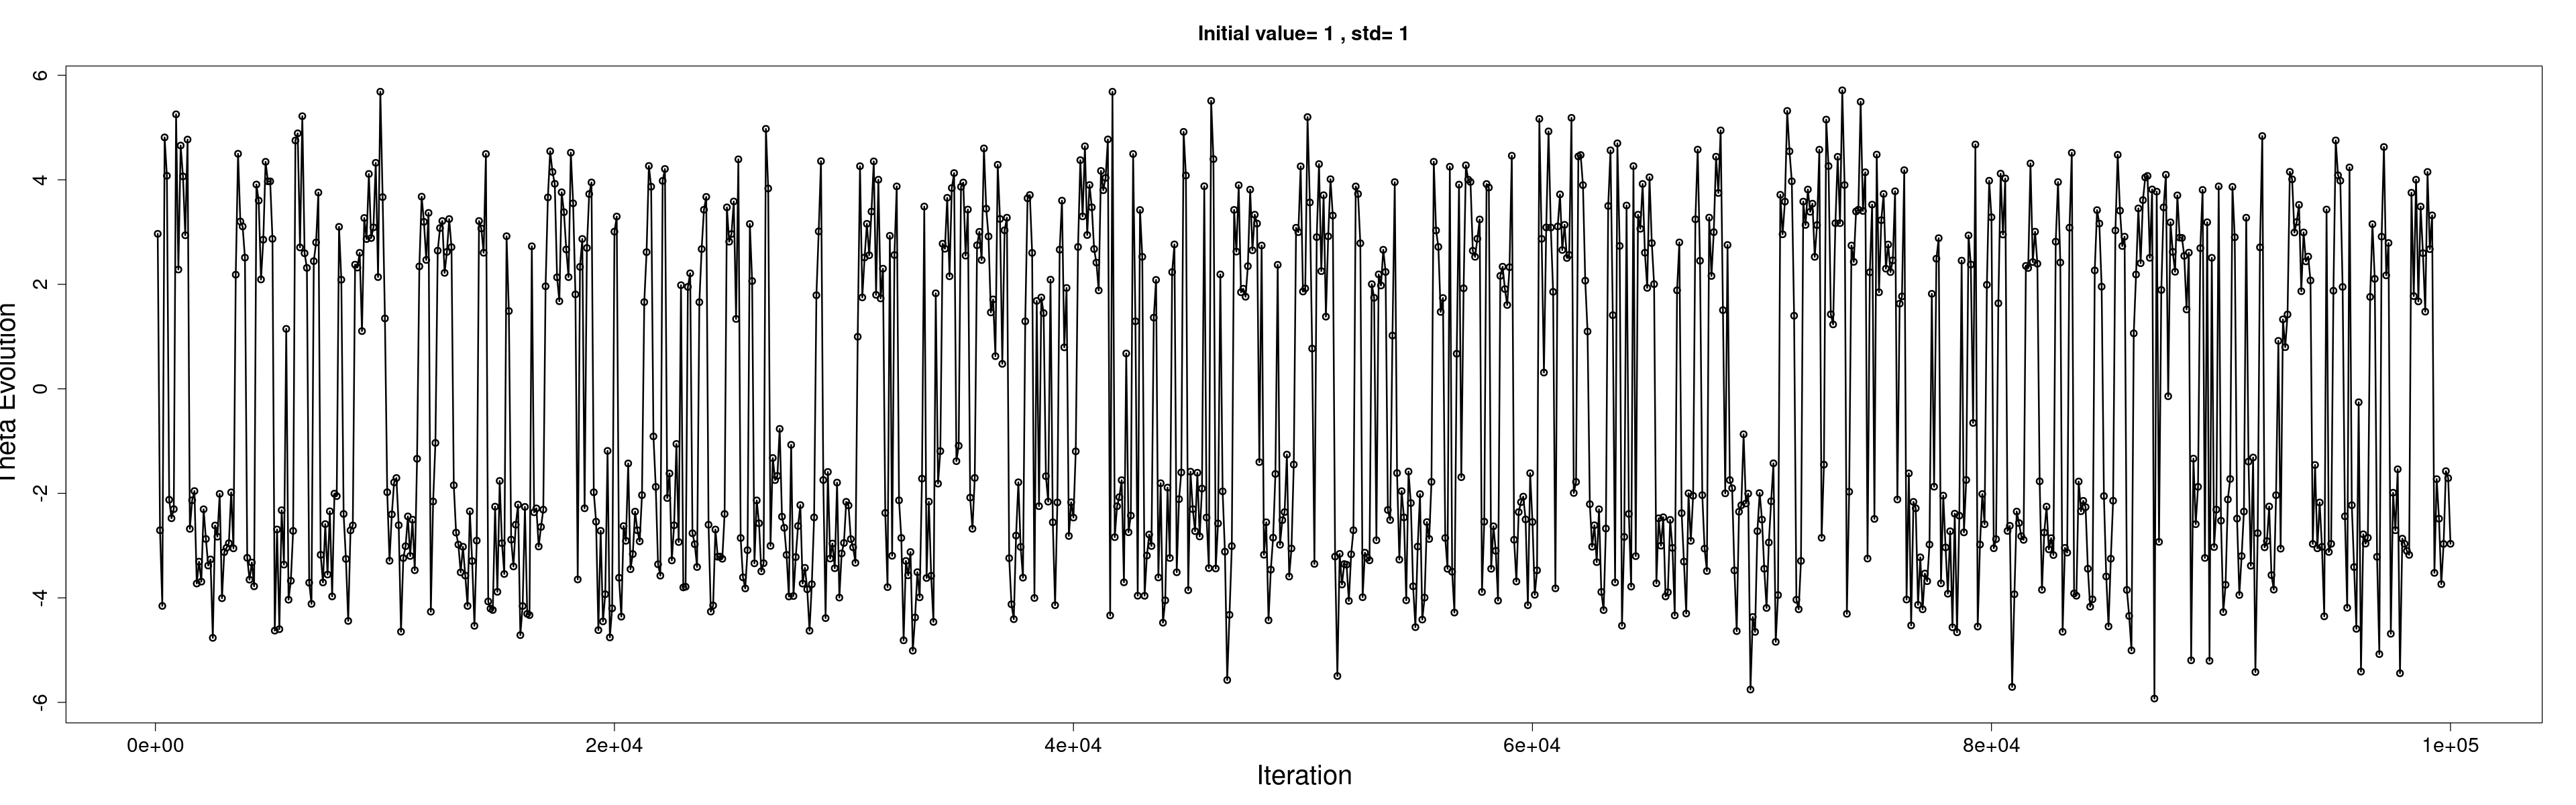

In [107]:
# The initial parameters

init <- 1 #initial theta
std <- 1    # the sigma
burn_in <- 1000
N <- as.integer(1e5) + burn_in

#use the previous cell function to find mcmc
mcmc_g = random_steps(theta_init = init, n_samples = N, sigma = std, print_accept=TRUE)
# Selecting the sequence after the burn-in
mcmc_g = mcmc_g[,2][burn_in:N] 

#now plot the evolution of the chain 
options(repr.plot.width= 32 , repr.plot.height=10)
steps <- 100
plot_g <- mcmc_g[seq(0 , length(mcmc_g) , steps)]
plot(1:length(plot_g)*steps , plot_g , type='o', lwd =2 , xlab = 'Iteration' , ylab= 'Theta Evolution' , main=paste('Initial value=', init , ', std=', std), cex.main =1.5 ,cex.lab=2 , cex.axis=1.5)

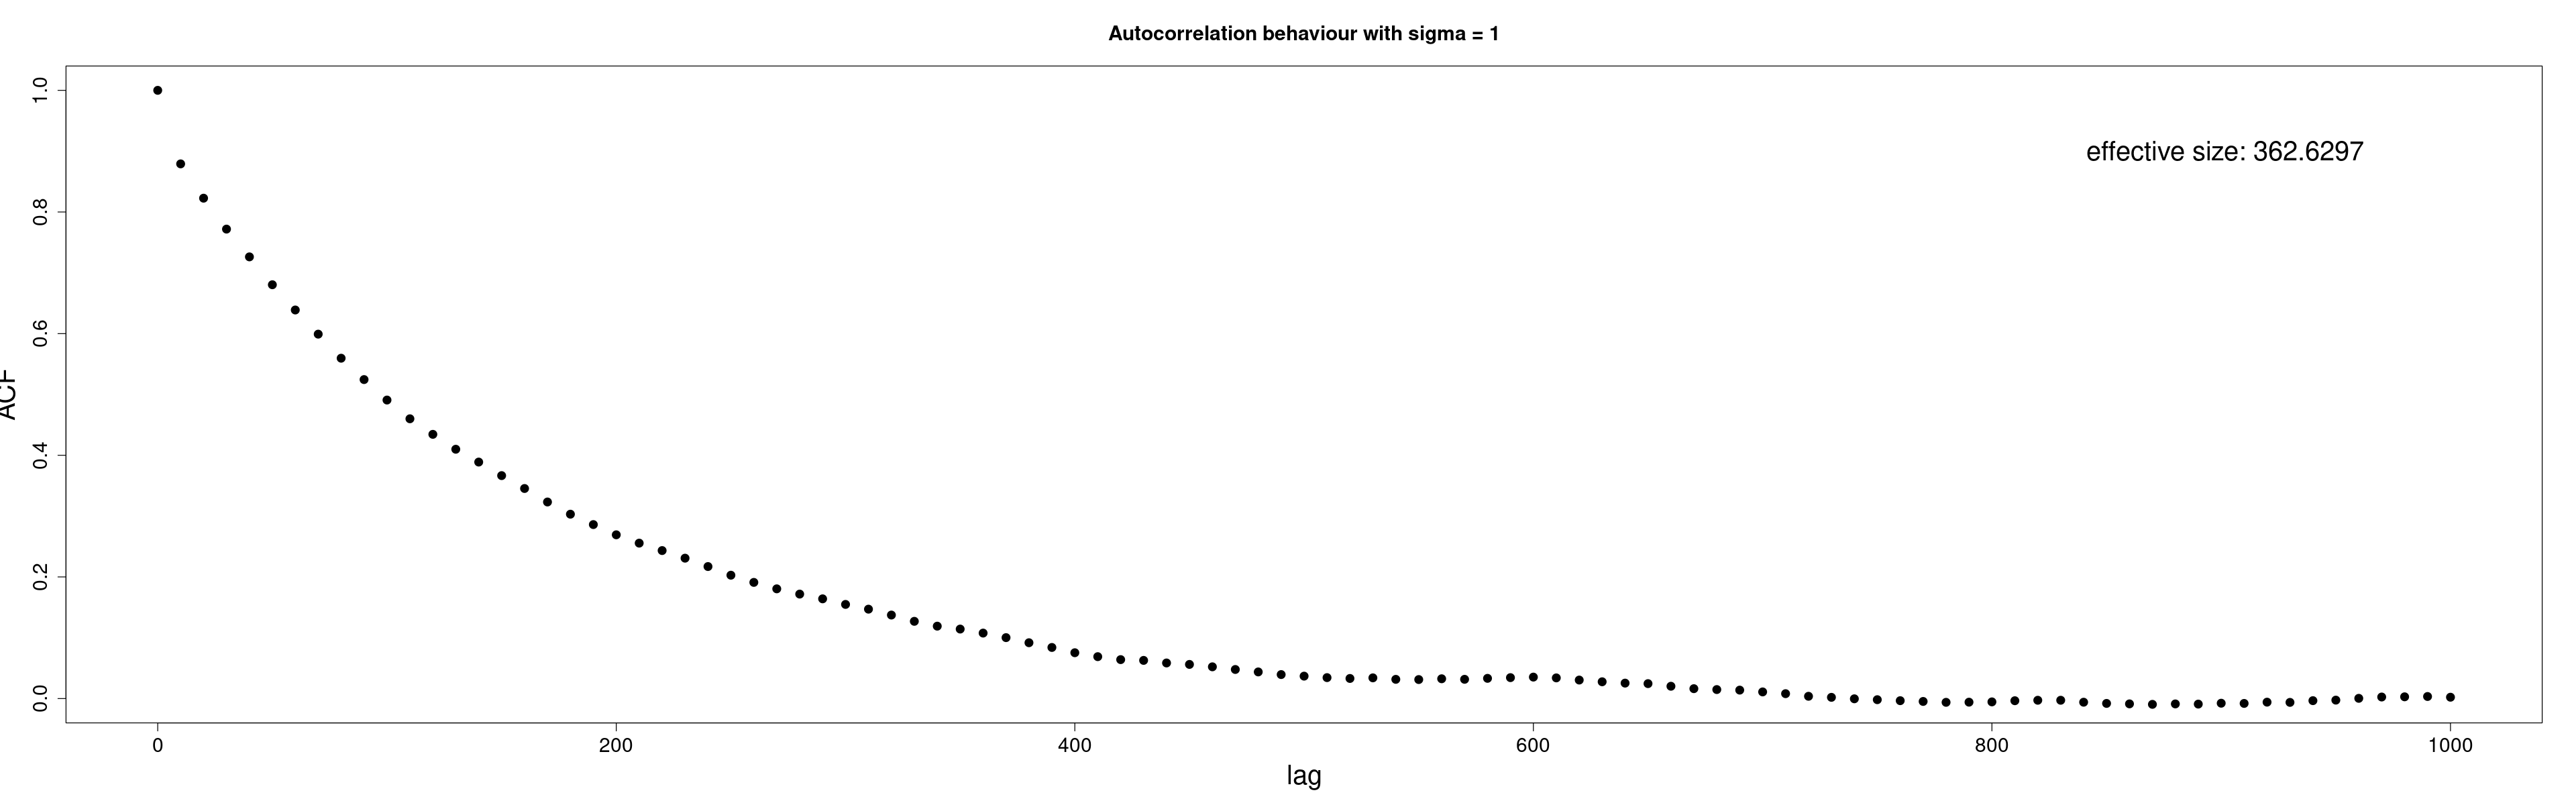

In [108]:
# Using CUDA

g_chain <- as.mcmc(mcmc_g)

lags <- seq(0,1000,10)
auto_g <- autocorr(g_chain, lags=lags)

#plot the autocorrelation evolution

plot(lags, auto_g, ylim=c(0,1), xlab="lag", ylab="ACF", cex=2, pch= 20,  main = paste("Autocorrelation behaviour with sigma =", std), cex.main =1.5 ,cex.lab=2 , cex.axis=1.5)
text(900,0.9, sprintf (" effective size: %.4f", effectiveSize(g_chain)), cex=2)

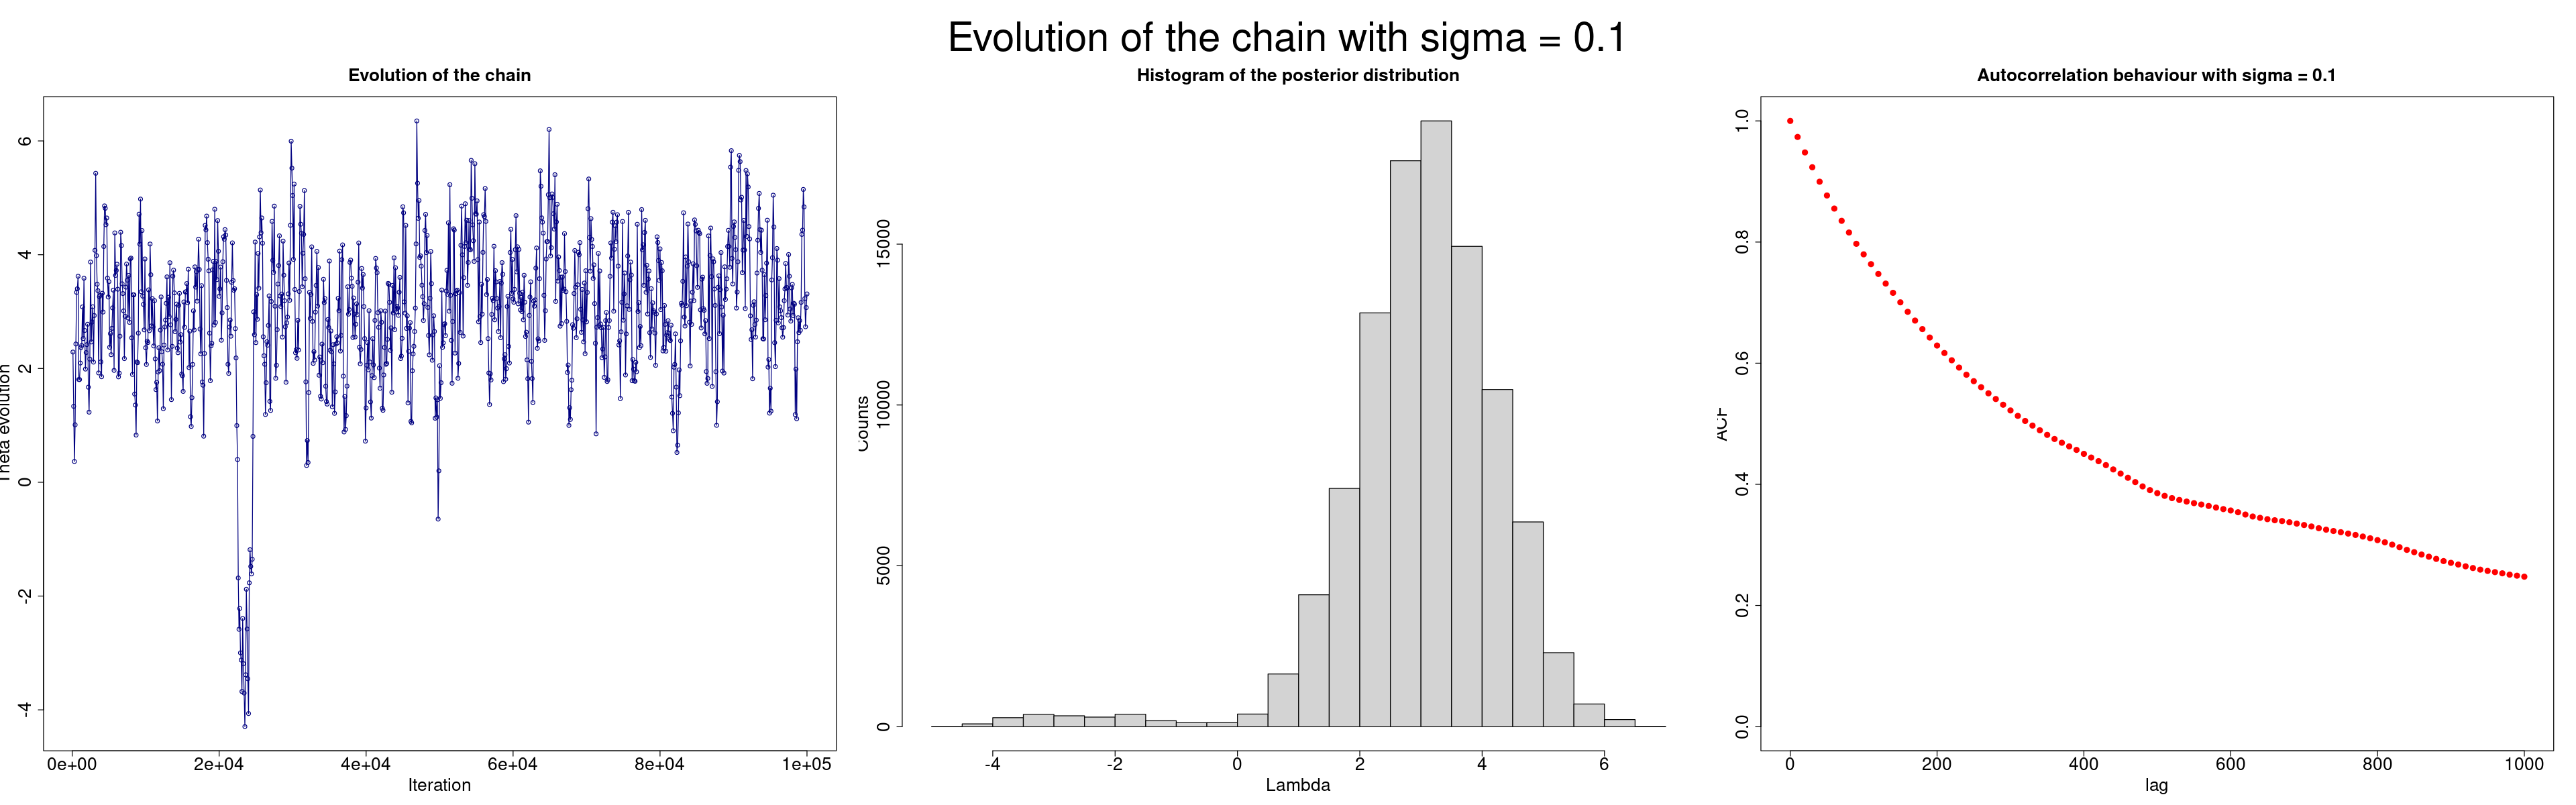

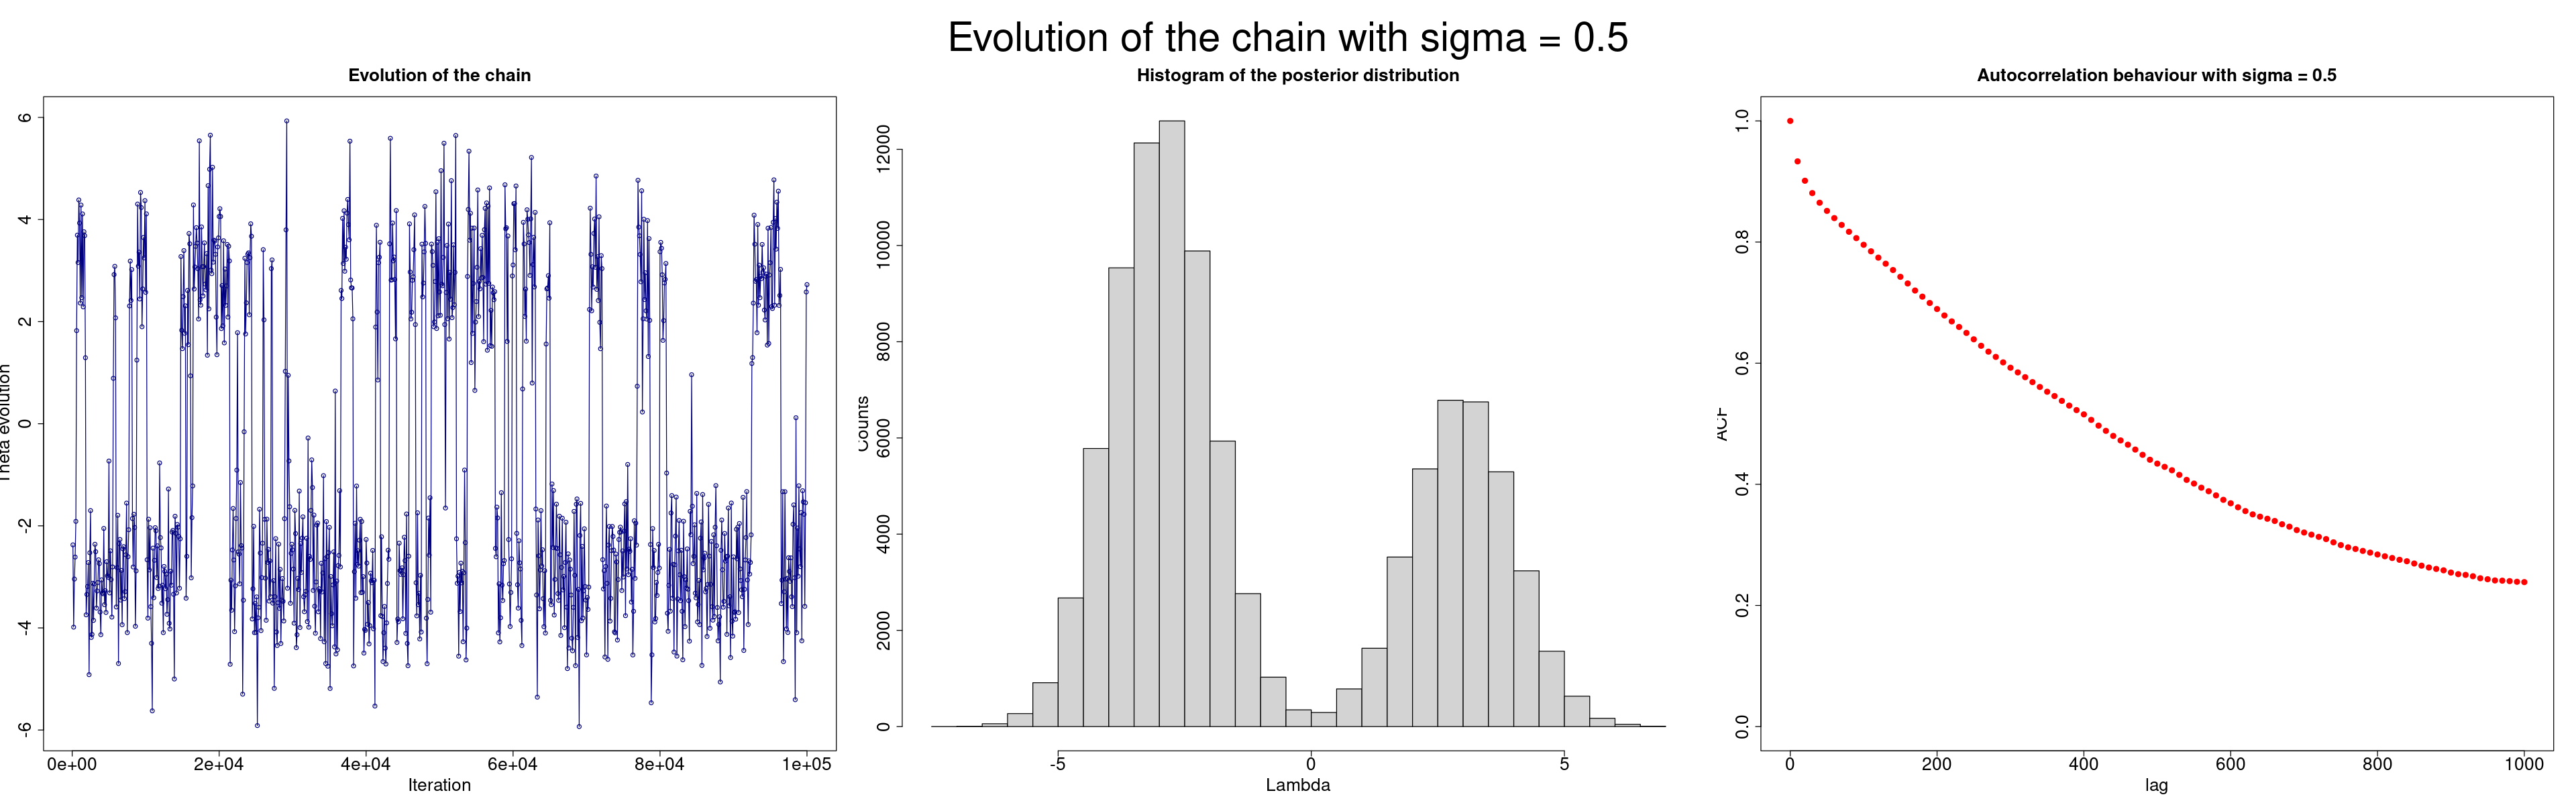

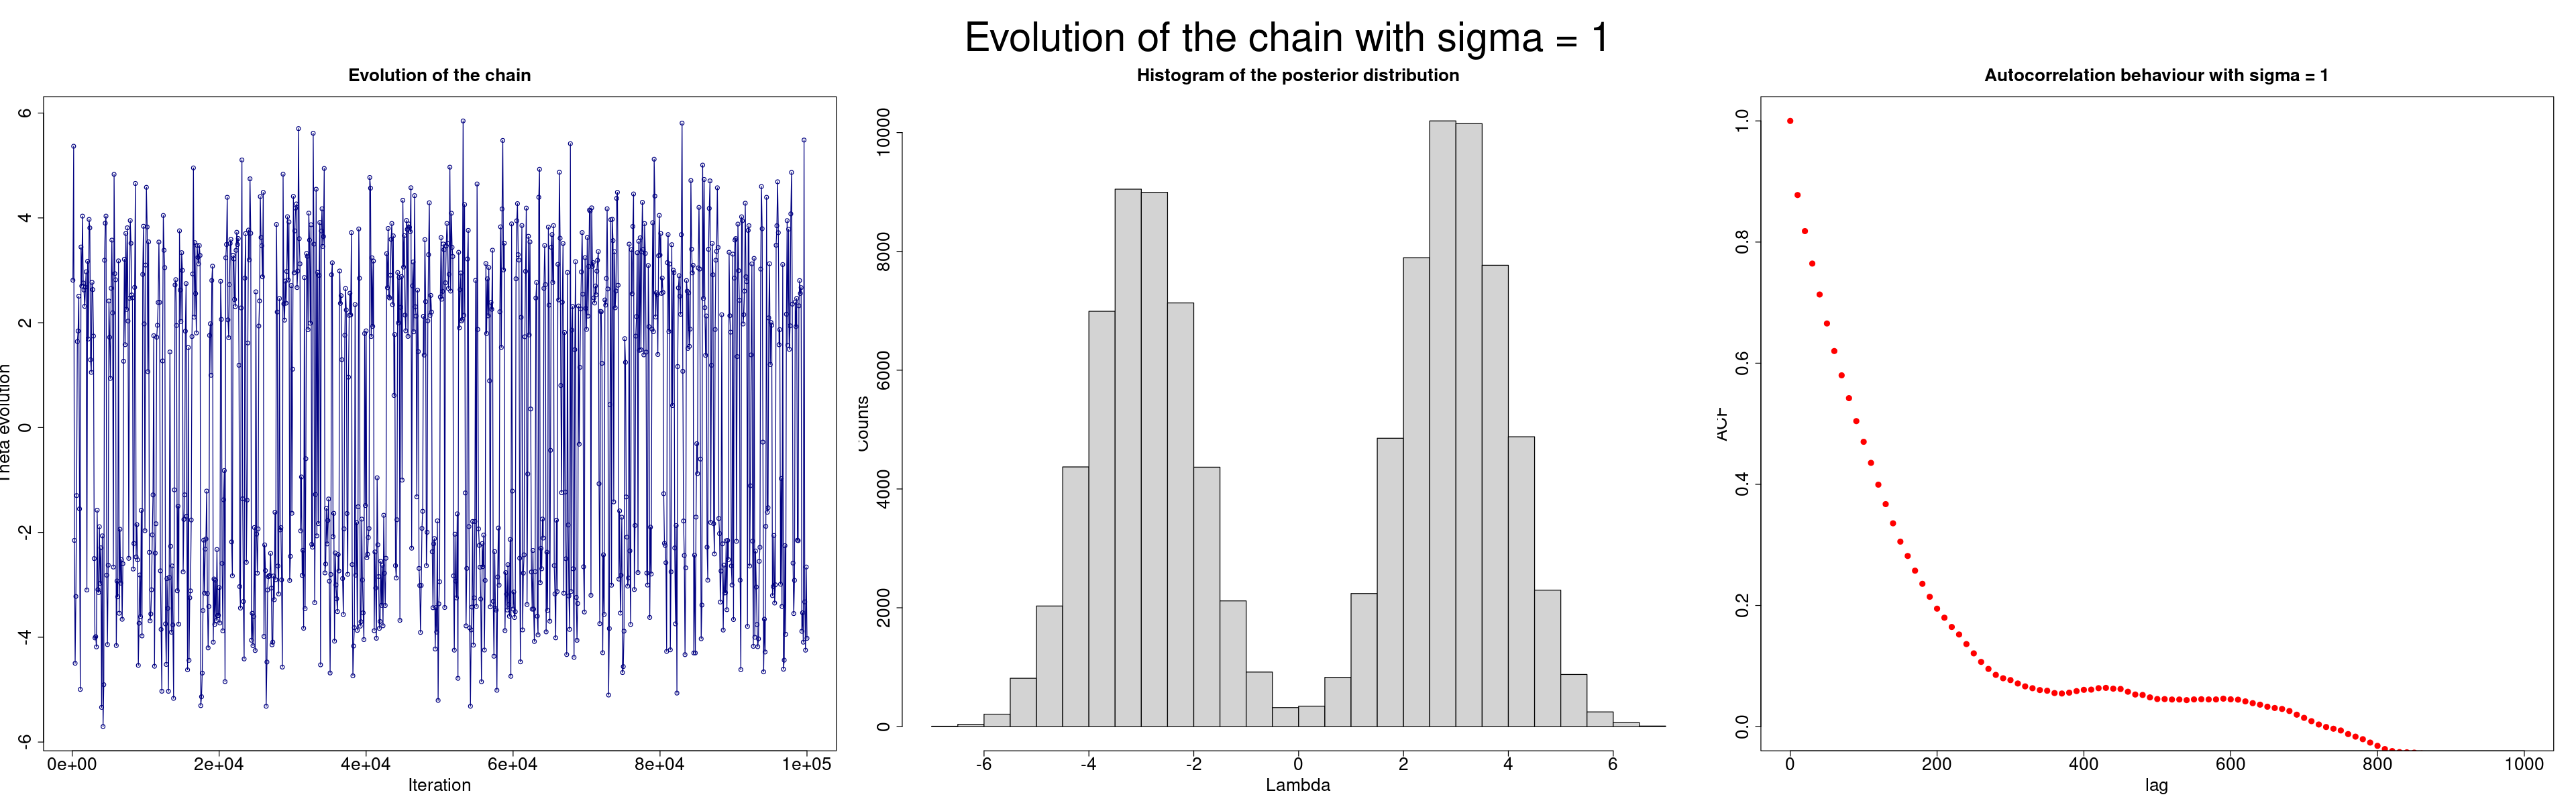

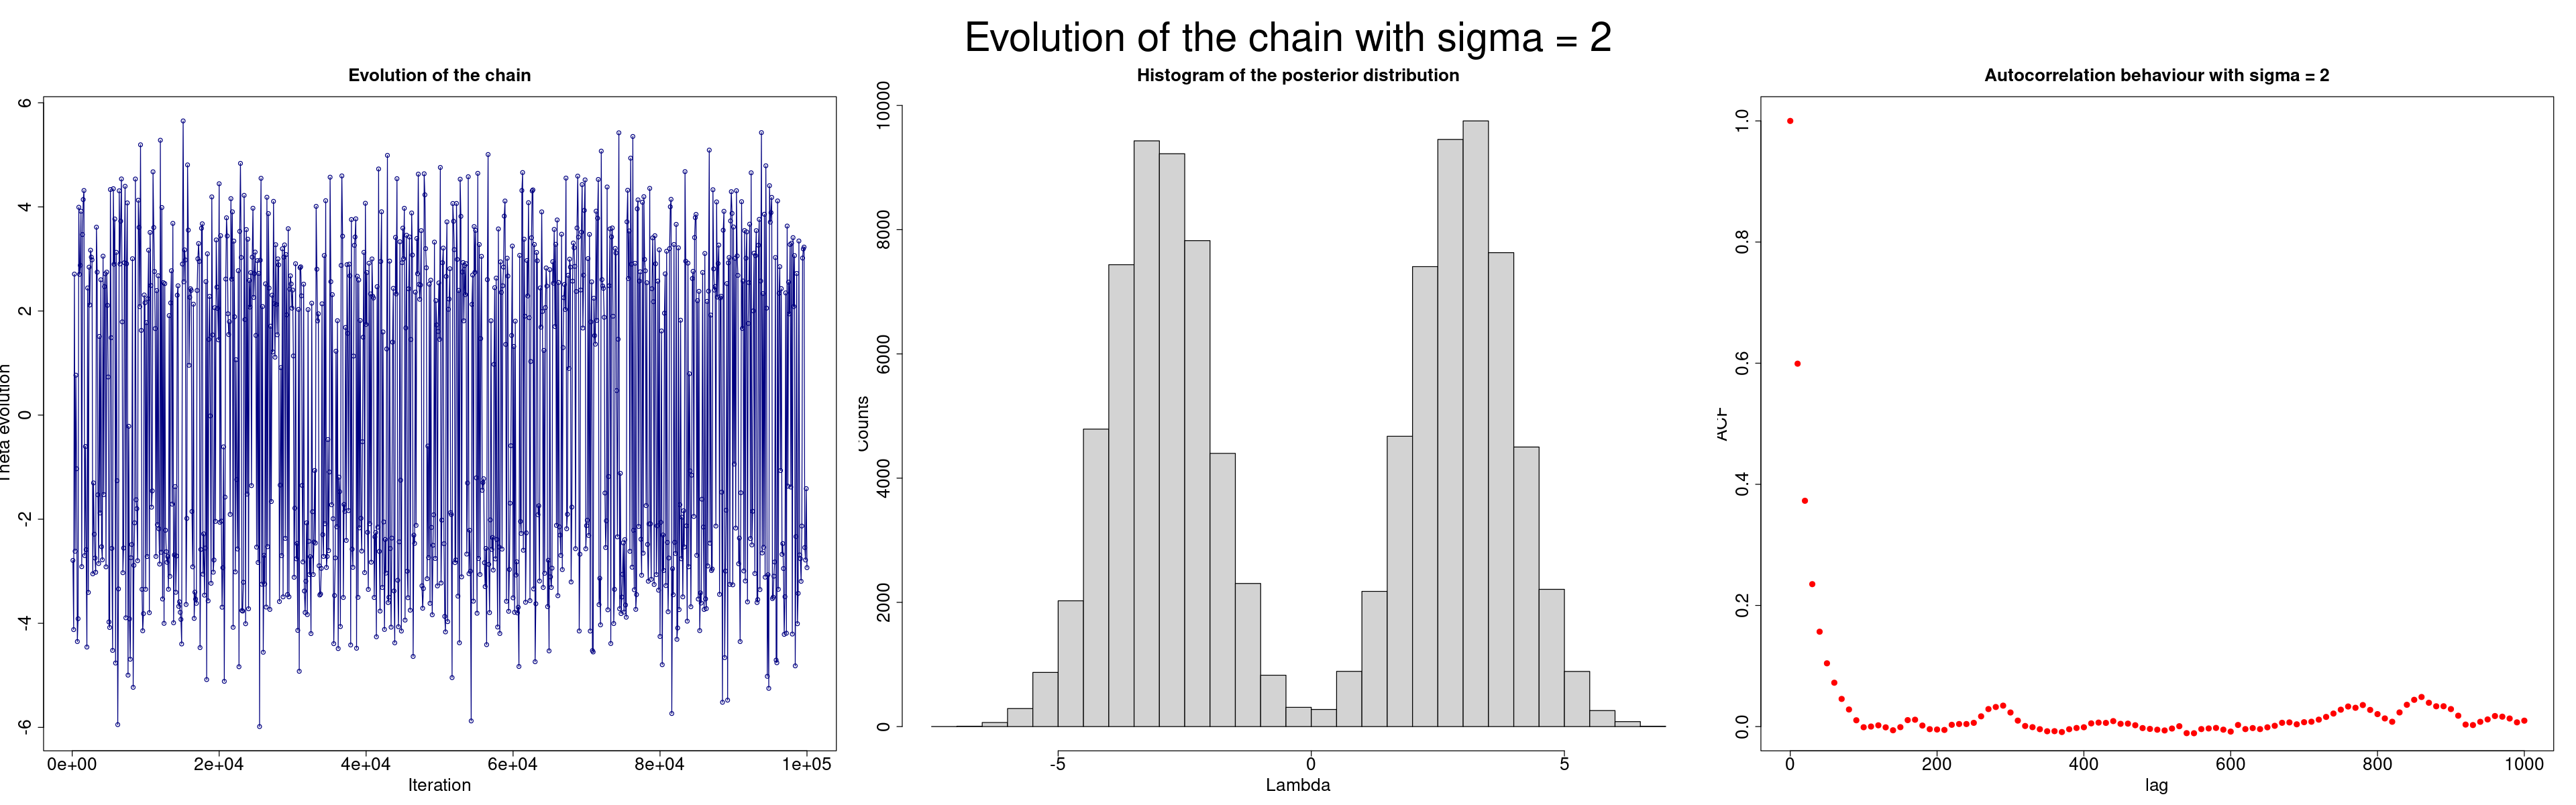

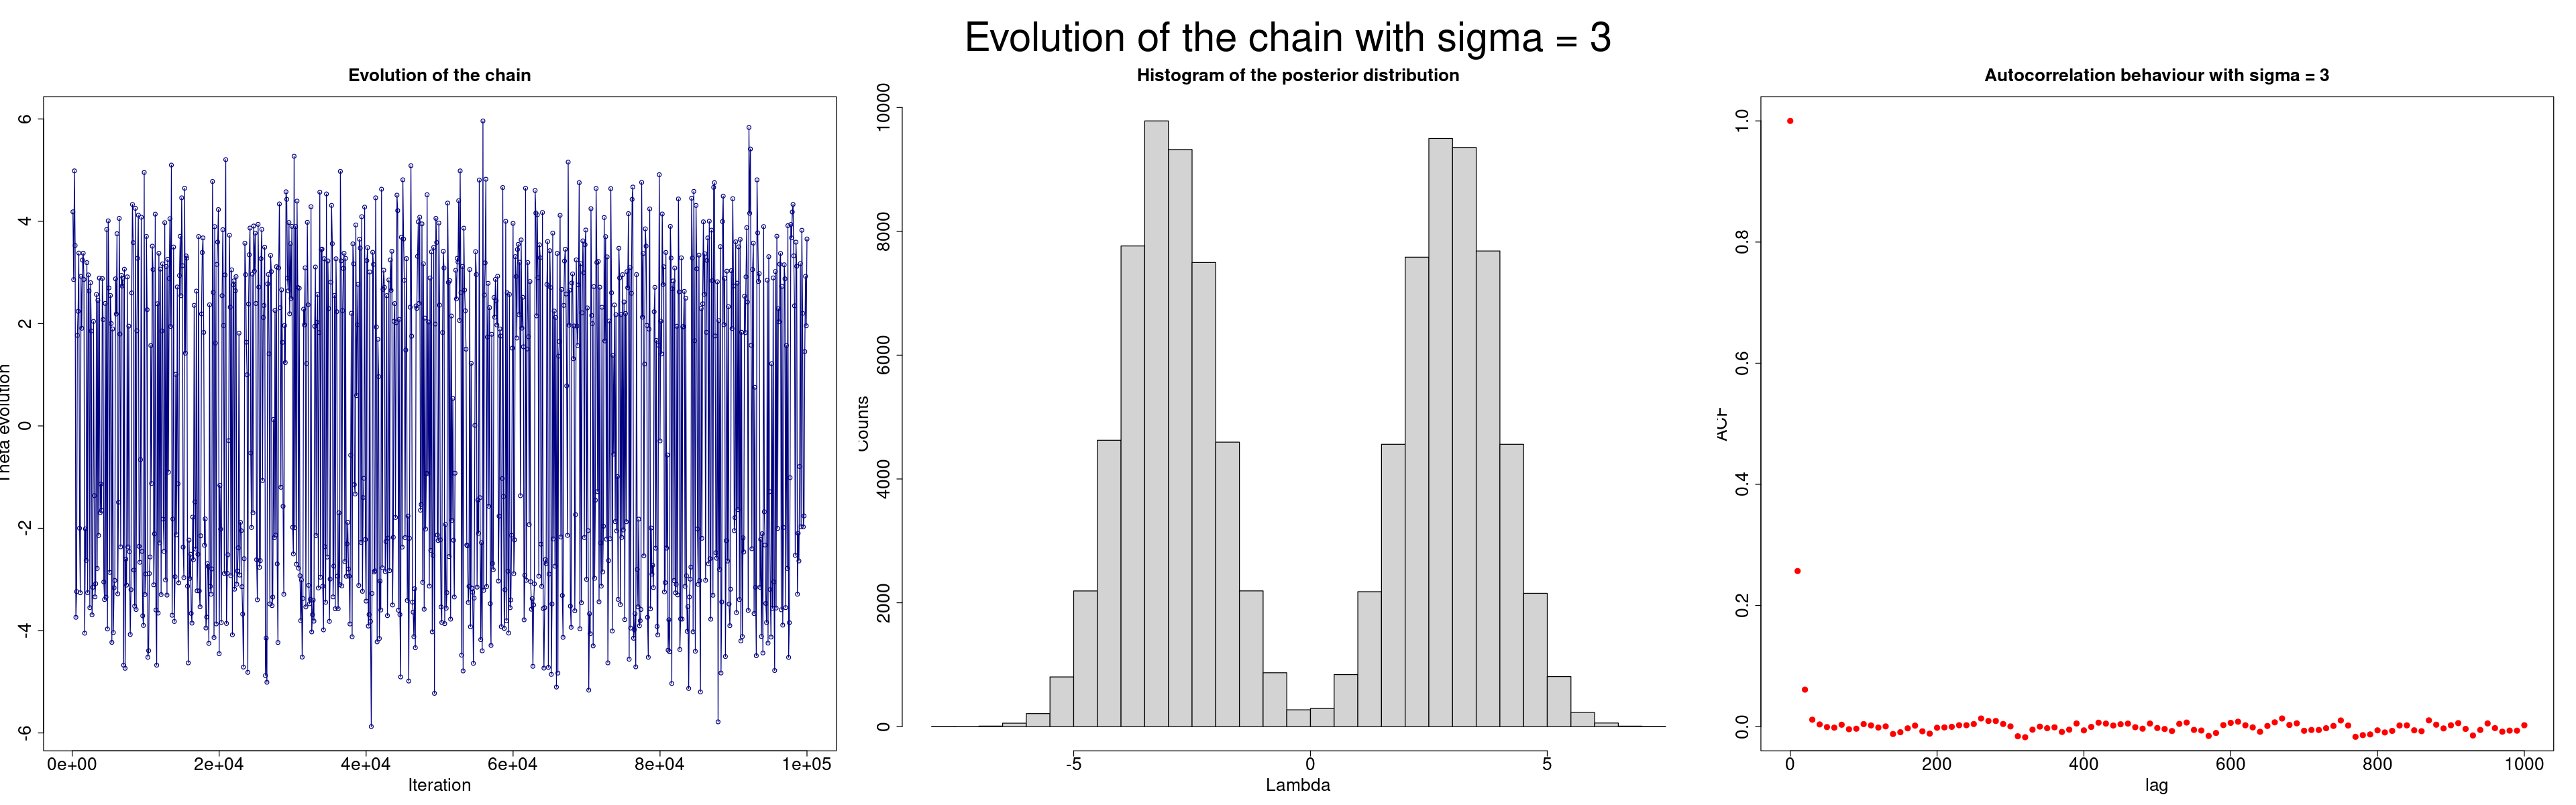

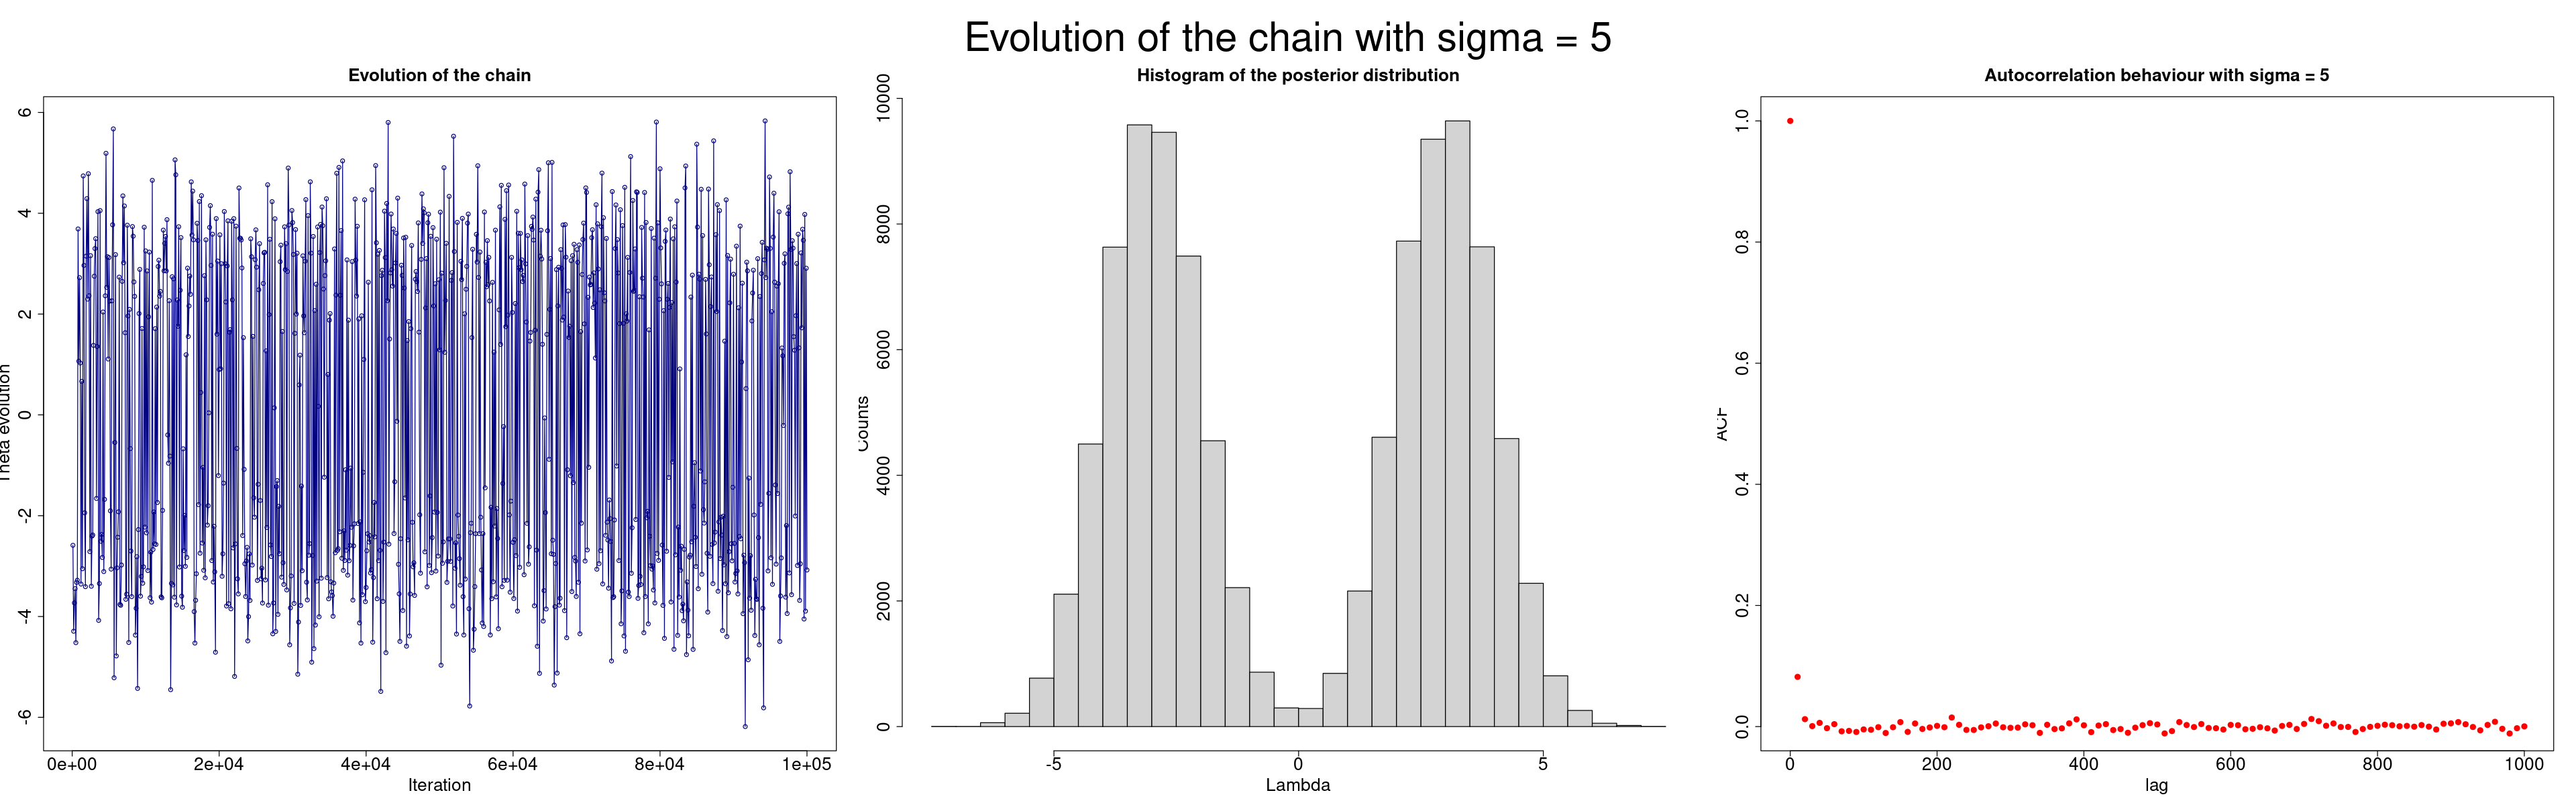

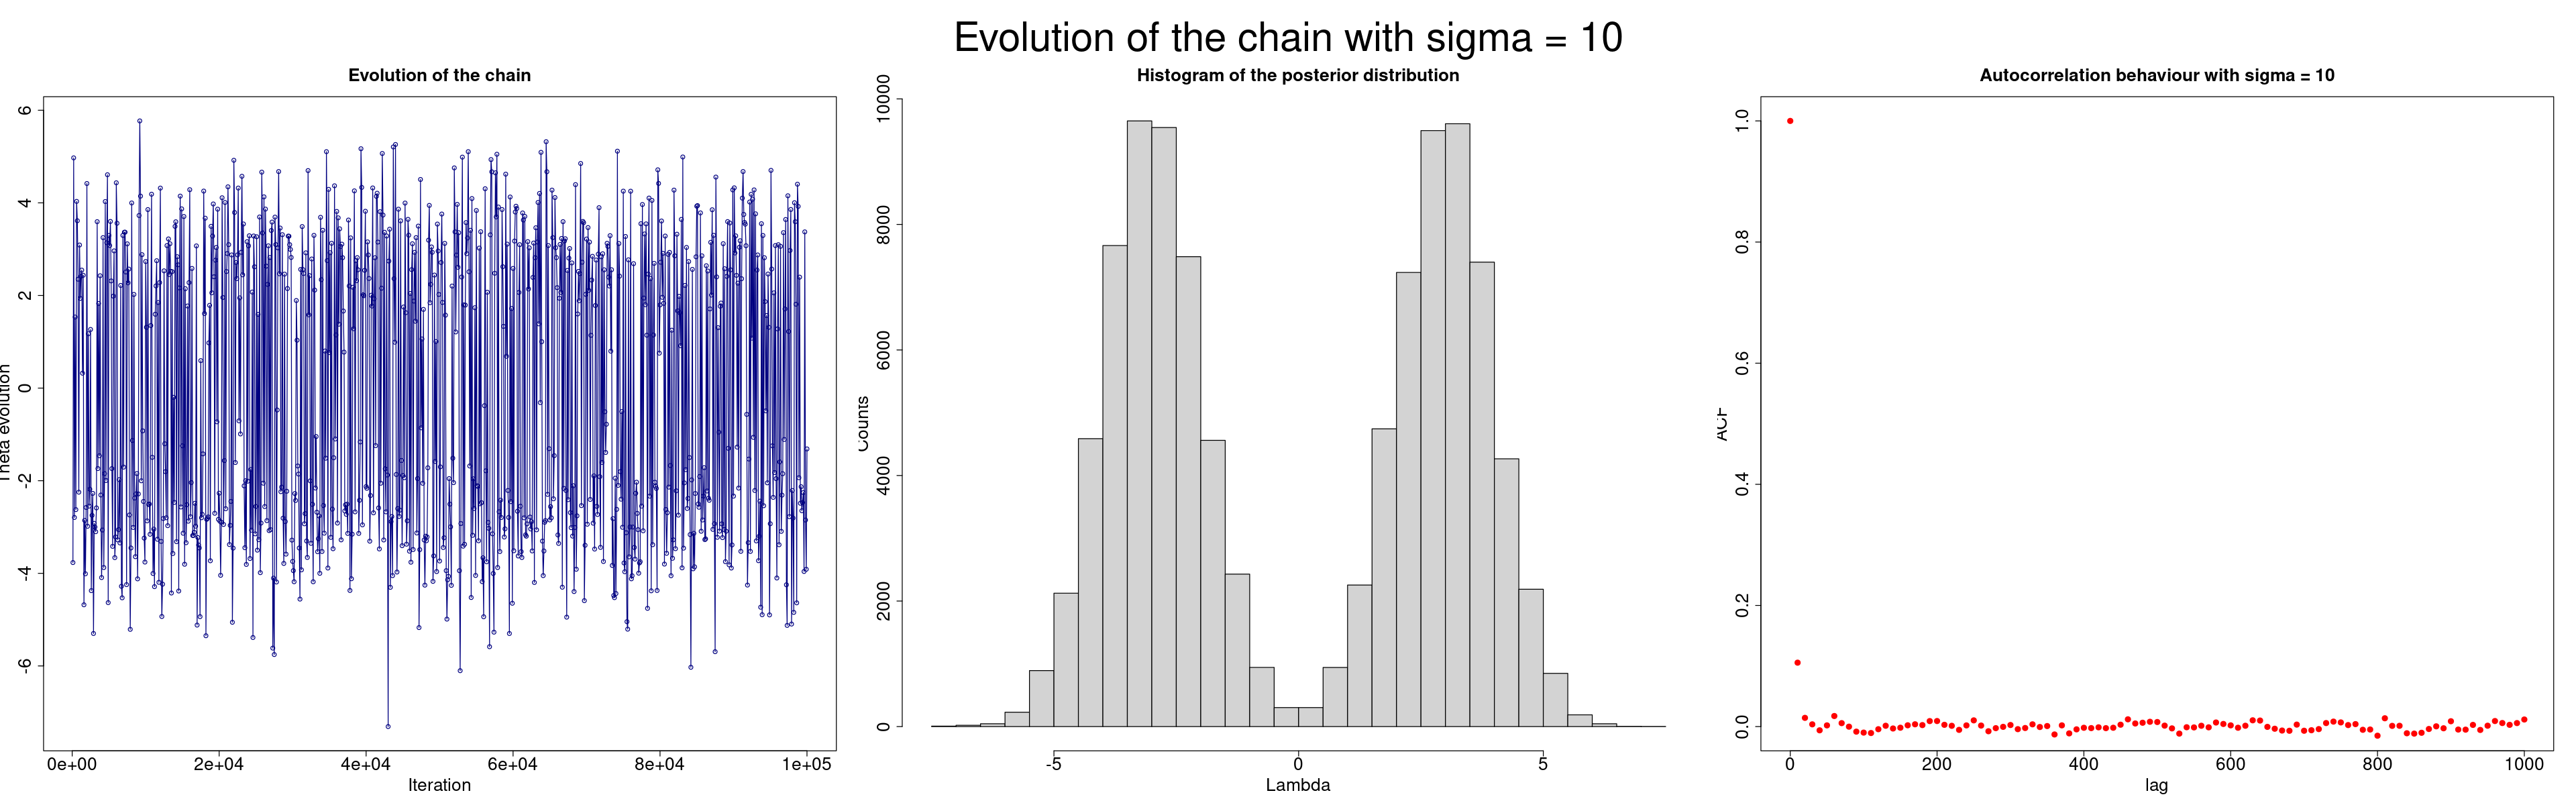

In [109]:
# Group of sigmas to loop on:
sigmas <- c(0.1, 0.5, 1, 2, 3, 5, 10)
func_change <- generation_function
# Other parameters useful to be defined again:
init <- 1 
std <- 1
burn_in <- 1000
N <- as.integer(1e5) + burn_in
lags <- seq(0,1000,10)


for (std in sigmas) {

    
    mcmc_g = random_steps( theta_init = init, n_samples = N, sigma = std, print_accept=FALSE)
    mcmc_g = mcmc_g[,2][burn_in:N] # Selecting the sequence after the burn-in
    g_chain = as.mcmc(mcmc_g)
    auto_g = autocorr(g_chain, lags=lags)

    # plot the results
    par(mfrow=c(1,3), oma = c(0, 0, 5, 0), cex.main =2 ,cex.lab=2 , cex.axis=2)
    options(repr.plot.width= 32 , repr.plot.height=10)
    steps = 100

    plot_g = mcmc_g[seq(0, length(mcmc_g), steps)] # I take a burn-in period
    plot(1:length(plot_g)*steps, plot_g, type = 'o', lwd = 1, col = 'navy', xlab = 'Iteration', ylab = 'Theta evolution', main = 'Evolution of the chain')
    
    hist(mcmc_g, breaks = 30, xlab = 'Lambda', ylab = 'Counts', main = 'Histogram of the posterior distribution' )
    
    plot(lags, auto_g, ylim=c(0,1), xlab="lag", ylab="ACF", cex=2, pch= 20,  main = paste("Autocorrelation behaviour with sigma =", std), col ='red')

    mtext(paste("Evolution of the chain with sigma =", std) , outer = TRUE, cex = 3, font = 1)
}


## Exersice 2

- analyze the initial test data reported on the EMA Web site for the following early Vaccines and create a Markow Chain Monte Carlo JAGS or stan the efficacy of each Vaccine. Infere the 95%
credibility interval.

In [78]:
#writing the model
modelstr <- 
"
model {
    # data likelihood
    for (i in 1:len_pos) {
        positive[i] ~ dbern(distribution[total[i]]);
    }
    
    # Beta(3,100) prior for each test
    for (j in 1:len_tot) {
        distribution[j] ~ dbeta(3, 100)
    }
}

"


writeLines(modelstr,'ex2.bug')

Data analyze for Jcovden(Janssen)
(Jcovden and Janssen data are the same)

Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 39321
   Unobserved stochastic nodes: 2
   Total graph size: 78648

Initializing model


Iterations = 1001:11000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

                     Mean        SD  Naive SE Time-series SE
distribution[1] 7.703e-05 4.421e-05 4.421e-07      4.421e-07
distribution[2] 8.238e-01 1.598e-02 1.598e-04      1.577e-04

2. Quantiles for each variable:

                     2.5%       25%       50%       75%     97.5%
distribution[1] 1.572e-05 4.457e-05 6.856e-05 9.976e-05 0.0001861
distribution[2] 7.921e-01 8.132e-01 8.239e-01 8.348e-01 0.8537274



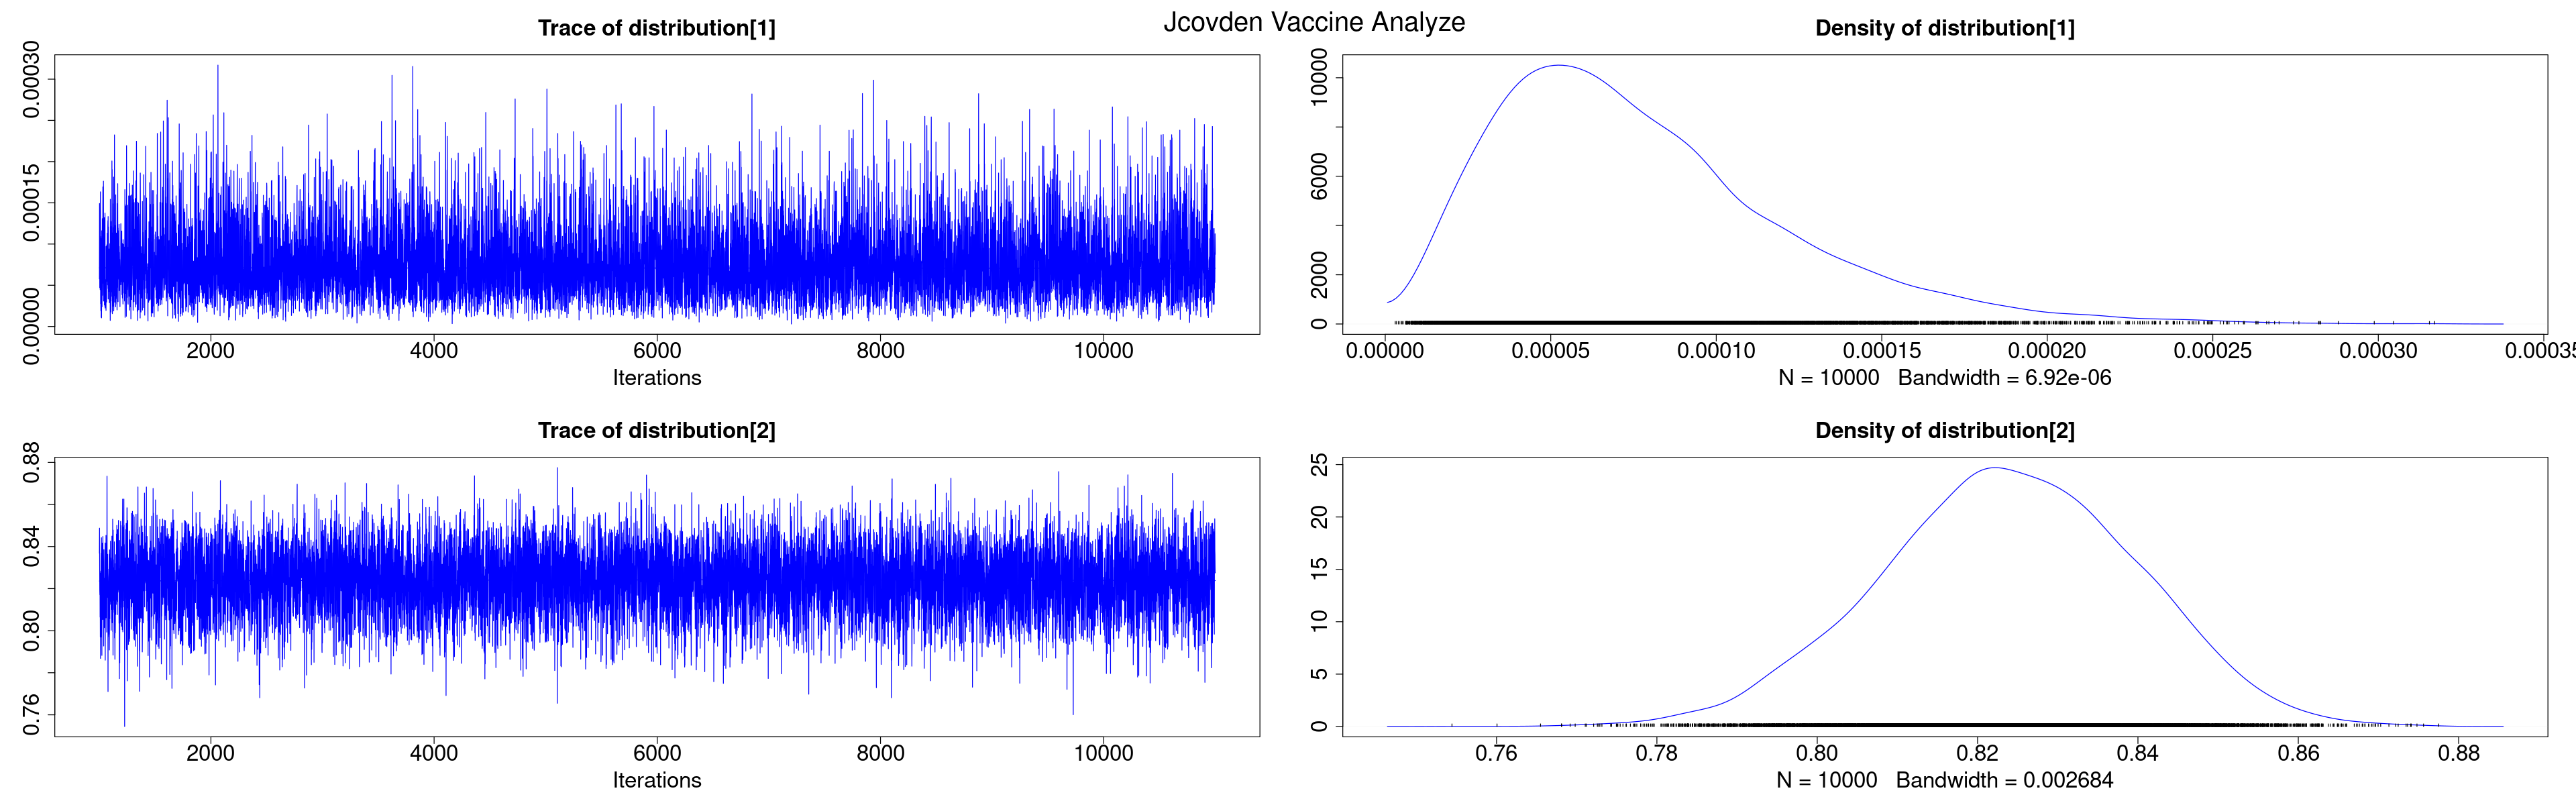

In [101]:
# first extract the initial data from the papers
vac_tot <- 19630
plac_tot <- 19691
vac_pos <- 116      #number of teted that was positive
plac_pos <- 348

tot <- c(rep("v", vac_tot) , rep('p', plac_tot) )
#print(length(unique(as.integer(factor(tot)))))
positive <- c(rep('positive', vac_pos), rep("negative" , vac_tot - vac_pos), 
            rep("positive", plac_pos), rep('negative', plac_tot - plac_pos) )

jcovden.tb <- tibble(test= positive , total= tot)

#create variables that are in our data

total <- as.integer(factor(jcovden.tb$test))
len_tot <- nlevels(factor(jcovden.tb))
positive <- ifelse(positive == "negative" , 0 , 1)
len_pos <- nrow(jcovden.tb)


#creat the data and put variables on it

data <- NULL
data$total <- total
data$len_tot <- len_tot
data$positive <- positive
data$len_pos <- len_pos


jags_model <- jags.model(file='ex2.bug', data=data)
update(jags_model, 1000)
#create a chain 
jan_chain <- coda.samples(jags_model , c('distribution') , n.iter=10000)
print(summary(jan_chain ))

#plotting the outputs
par(cex.main=2, cex.lab=2 , cex.axis=2)     #increase the size of title, x and y axis for all plots
plot(jan_chain, col = 'blue', cex.main =2 ,cex.lab=2 , cex.axis=2)
mtext(paste("Jcovden Vaccine Analyze") , side=3, line =2,cex = 2, font = 1)

In [80]:
# the method to calculate credibility interval and other variables of the data
print('Jcovden Vaccine dataframe')
Jcovden_chains <- run.jags(modelstr ,
                           sample = 10000,
                           n.chains = 4,
                           method = "parallel",
                           monitor = "distribution",
                           data = data )
summary(Jcovden_chains)

[1] "Jcovden Vaccine dataframe"


Warning message:
“No initial values were provided - JAGS will use the same initial values for all chains”
Warning message:
“You attempted to start parallel chains without setting different PRNG for each chain, which is not recommended.  Different .RNG.name values have been added to each set of initial values.”


Calling 4 simulations using the parallel method...
Following the progress of chain 1 (the program will wait for all chains
to finish before continuing):
Welcome to JAGS 4.3.2 on Mon Jun  5 14:31:57 2023
JAGS is free software and comes with ABSOLUTELY NO WARRANTY
Loading module: basemod: ok
Loading module: bugs: ok
. . Reading data file data.txt
. Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 39321
   Unobserved stochastic nodes: 2
   Total graph size: 78648
. Reading parameter file inits1.txt
. Initializing model
. Adaptation skipped: model is not in adaptive mode.
. Updating 4000
-------------------------------------------------| 4000
************************************************** 100%
. . Updating 10000
-------------------------------------------------| 10000
************************************************** 100%
. . . . Updating 0
. Deleting model
All chains have finished
Note: the model did not requ

Lower95     Median       Upper95    Mean         SD          
distribution[1] 9.24935e-06 0.0000688479 0.00016689 7.711042e-05 0.0000444735
distribution[2] 7.91333e-01 0.8241645000 0.85345900 8.237182e-01 0.0159665645
                Mode MCerr        MC%ofSD SSeff AC.10        psrf     
distribution[1] NA   2.199130e-07 0.5     40898 -0.005257402 1.0001210
distribution[2] NA   7.983282e-05 0.5     40000 -0.001215469 0.9999828

Data analys for Moderna

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 28207
   Unobserved stochastic nodes: 2
   Total graph size: 67534

Initializing model


Iterations = 1001:11000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

                    Mean        SD  Naive SE Time-series SE
distribution[1] 0.006748 0.0004902 4.902e-06      4.902e-06
distribution[2] 0.024724 0.0065211 6.521e-05      6.521e-05

2. Quantiles for each variable:

                    2.5%     25%      50%      75%    97.5%
distribution[1] 0.005806 0.00641 0.006742 0.007073 0.007747
distribution[2] 0.013458 0.02012 0.024191 0.028673 0.039118



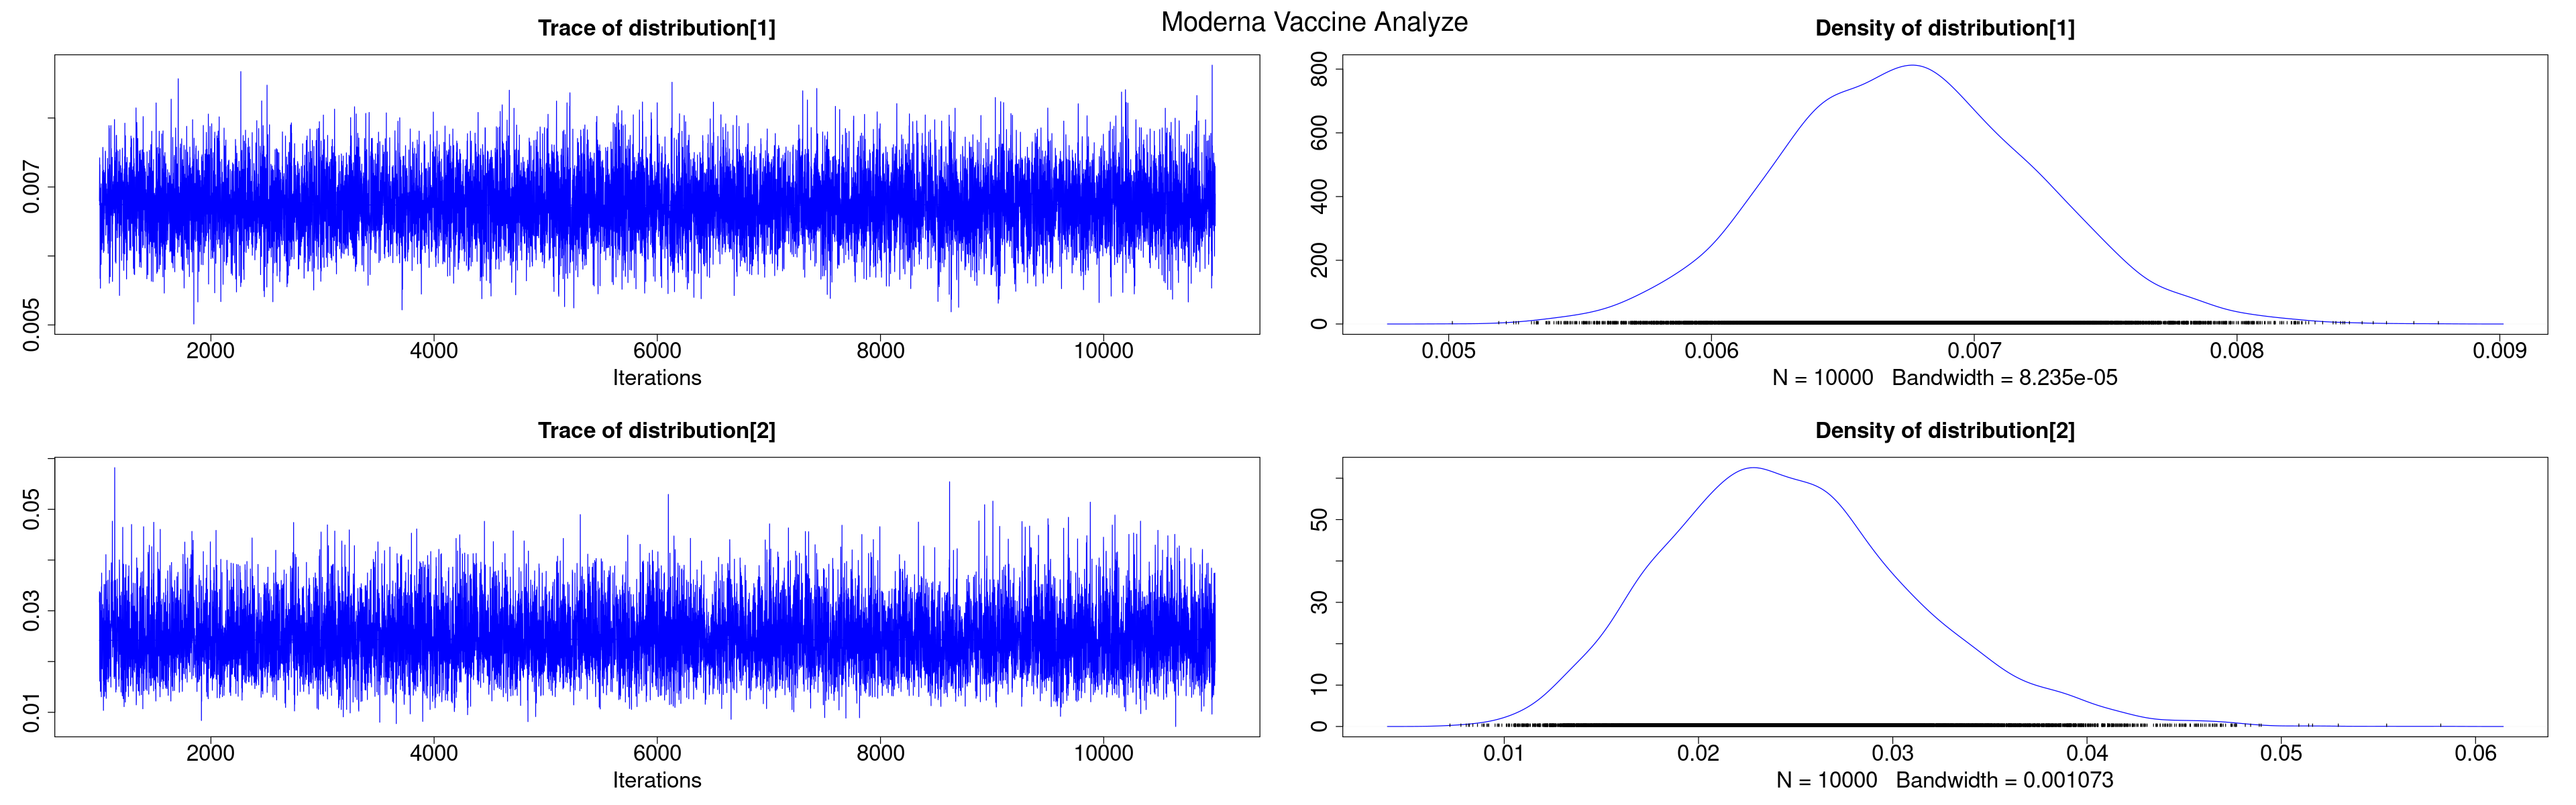

In [102]:
vac_tot <- 14134
plac_tot <- 14073
vac_pos <- 11      #number of teted that was positive
plac_pos <- 185

tot <- c(rep("v", vac_tot) , rep('p', plac_tot) )
#print(length(unique(as.integer(factor(tot)))))
positive <- c(rep('positive', vac_pos), rep("negative" , vac_tot - vac_pos), 
            rep("positive", plac_pos), rep('negative', plac_tot - plac_pos) )

#create a list of our data


total <- as.integer(factor(total))
len_tot <- length(unique(total))
positive <- ifelse(positive == "negative" , 0 , 1)
len_pos <- length(positive)

data <- NULL
data$total <- total
data$len_tot <- len_tot
data$positive <- positive
data$len_pos <- len_pos

jags_model <- jags.model('ex2.bug', data=data)
update(jags_model, 1000)
#create a chain 
moderna_chain <- coda.samples(jags_model , c('distribution') , n.iter=10000)
print(summary(moderna_chain ))

#plotting the outputs
par(cex.main=2, cex.lab=2 , cex.axis=2)     #increase the size of title, x and y axis for all plots
plot(moderna_chain, col= 'blue',cex.main =2 ,cex.lab=2 , cex.axis=2)
mtext(paste("Moderna Vaccine Analyze") , side=3, line =2,cex = 2, font = 1)


In [85]:
# the method to calculate credibility interval and other variables
print("Moderna Vaccine dataframe")
Moderna_chains <- run.jags(modelstr ,
                           sample = 10000,
                           n.chains = 4,
                           method = "parallel",
                           monitor = "distribution",
                           data = data )
summary(Moderna_chains)



[1] "Moderna Vaccine dataframe"


Warning message:
“No initial values were provided - JAGS will use the same initial values for all chains”
Warning message:
“You attempted to start parallel chains without setting different PRNG for each chain, which is not recommended.  Different .RNG.name values have been added to each set of initial values.”


Calling 4 simulations using the parallel method...
Following the progress of chain 1 (the program will wait for all chains
to finish before continuing):
Welcome to JAGS 4.3.2 on Mon Jun  5 14:37:11 2023
JAGS is free software and comes with ABSOLUTELY NO WARRANTY
Loading module: basemod: ok
Loading module: bugs: ok
. . Reading data file data.txt
. Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 28207
   Unobserved stochastic nodes: 2
   Total graph size: 67534
. Reading parameter file inits1.txt
. Initializing model
. Adaptation skipped: model is not in adaptive mode.
. Updating 4000
-------------------------------------------------| 4000
************************************************** 100%
. . Updating 10000
-------------------------------------------------| 10000
************************************************** 100%
. . . . Updating 0
. Deleting model
. 
All chains have finished
Note: the model did not r

Lower95    Median      Upper95    Mean        SD           Mode
distribution[1] 0.00577286 0.006740065 0.00769856 0.006750886 0.0004926141 NA  
distribution[2] 0.01289750 0.024132950 0.03793250 0.024674287 0.0065148950 NA  
                MCerr        MC%ofSD SSeff AC.10         psrf     
distribution[1] 2.450932e-06 0.5     40397 -0.0003388818 1.0000601
distribution[2] 3.269571e-05 0.5     39704 -0.0023859998 0.9999764

Data analyse for AstraZeneca(Vaxzeviria)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 10468
   Unobserved stochastic nodes: 2
   Total graph size: 49795

Initializing model


Iterations = 1001:11000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

                   Mean       SD  Naive SE Time-series SE
distribution[1] 0.01502 0.001192 1.192e-05      1.192e-05
distribution[2] 0.30647 0.031091 3.109e-04      3.109e-04

2. Quantiles for each variable:

                   2.5%    25%     50%     75%   97.5%
distribution[1] 0.01275 0.0142 0.01498 0.01582 0.01743
distribution[2] 0.24814 0.2846 0.30585 0.32733 0.36952



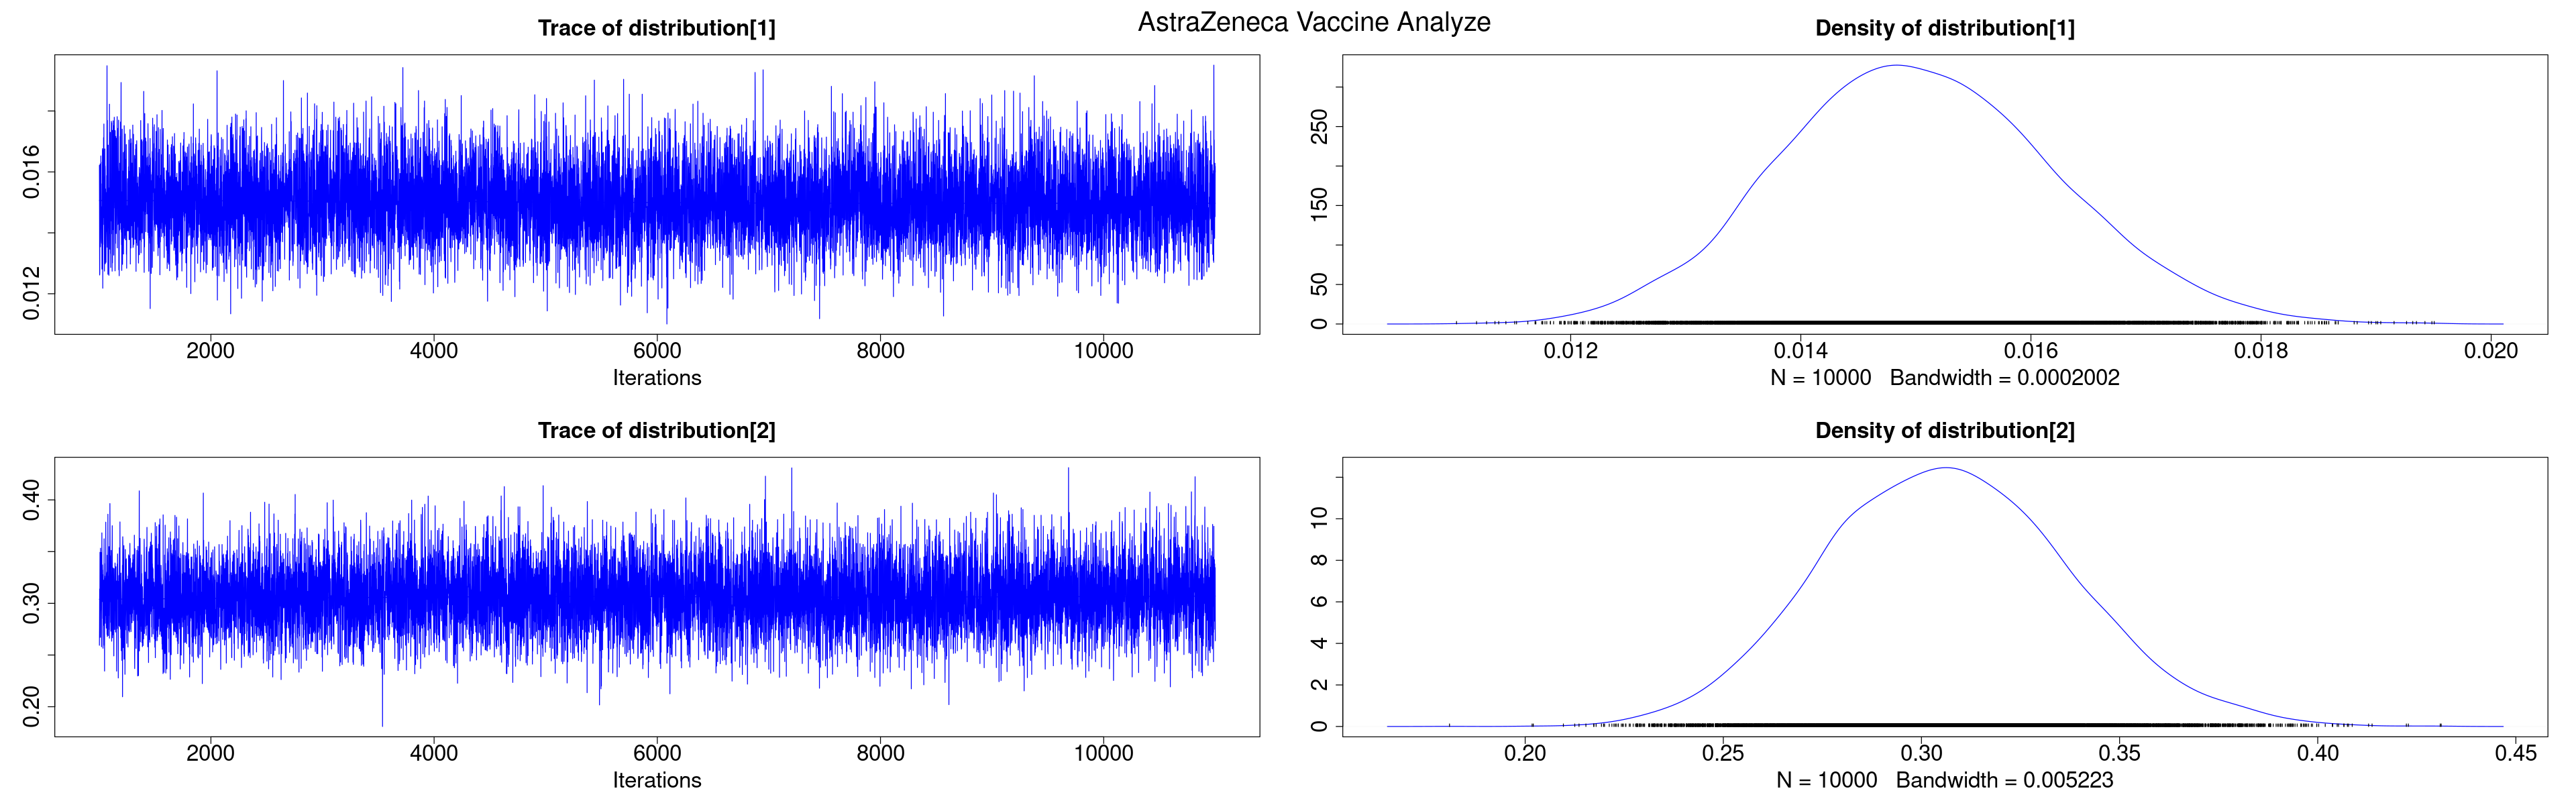

In [100]:
vac_tot <- 5258
plac_tot <- 5210
vac_pos <- 64     #number of teted that was positive
plac_pos <- 154

tot <- c(rep("v", vac_tot) , rep('p', plac_tot) )
#print(length(unique(as.integer(factor(tot)))))
positive <- c(rep('positive', vac_pos), rep("negative" , vac_tot - vac_pos), 
            rep("positive", plac_pos), rep('negative', plac_tot - plac_pos) )

#create a list of our data


total <- as.integer(factor(total))
len_tot <- length(unique(total))
positive <- ifelse(positive == "negative" , 0 , 1)
len_pos <- length(positive)


data <- NULL
data$total <- total
data$len_tot <- len_tot
data$positive <- positive
data$len_pos <- len_pos


jags_model <- jags.model('ex2.bug', data=data)
update(jags_model, 1000)
#create a chain 
astra_chain <- coda.samples(jags_model , c('distribution') , n.iter=10000)
print(summary(astra_chain ))

#plotting the outputs
par(cex.main=2, cex.lab=2 , cex.axis=2)     #increase the size of title, x and y axis for all plots
plot(astra_chain, col='blue', cex.main =2 )
mtext(paste("AstraZeneca Vaccine Analyze") , side=3, line =2,cex = 2, font = 1)


In [87]:
# the method to calculate credibility interval and other variables
print("AstraZeneca Vaccine dataframe")
Astra_chains <- run.jags(modelstr ,
                           sample = 10000,
                           n.chains = 4,
                           method = "parallel",
                           monitor = "distribution",
                           data = data )
summary(Astra_chains)



[1] "AstraZeneca Vaccine dataframe"


Warning message:
“No initial values were provided - JAGS will use the same initial values for all chains”
Warning message:
“You attempted to start parallel chains without setting different PRNG for each chain, which is not recommended.  Different .RNG.name values have been added to each set of initial values.”


Calling 4 simulations using the parallel method...
Following the progress of chain 1 (the program will wait for all chains
to finish before continuing):
Welcome to JAGS 4.3.2 on Mon Jun  5 14:39:20 2023
JAGS is free software and comes with ABSOLUTELY NO WARRANTY
Loading module: basemod: ok
Loading module: bugs: ok
. . Reading data file data.txt
. Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 10468
   Unobserved stochastic nodes: 2
   Total graph size: 49795
. Reading parameter file inits1.txt
. Initializing model
. Adaptation skipped: model is not in adaptive mode.
. Updating 4000
-------------------------------------------------| 4000
************************************************** 100%
. . Updating 10000
-------------------------------------------------| 10000
************************************************** 100%
. . . . Updating 0
. Deleting model
. 
All chains have finished
Note: the model did not r

Lower95   Median     Upper95   Mean       SD          Mode
distribution[1] 0.0126808 0.01497785 0.0173325 0.01500962 0.001188033 NA  
distribution[2] 0.2440400 0.30543900 0.3655070 0.30593508 0.031128650 NA  
                MCerr        MC%ofSD SSeff AC.10        psrf     
distribution[1] 5.917508e-06 0.5     40307  0.004788792 1.0000955
distribution[2] 1.559733e-04 0.5     39831 -0.000147977 0.9999951

## Exeersice 3

In [3]:
data <- read.csv('~/proj/owid-covid-data.csv')

world <-  data[data$locations == "World", ]  #put all the world values in a single data frame

world$date <- as.Date.character(world$date , "%Y-%m-%d")
world$week <- week(world$date)
world$year <- as.numeric(format(world$date , '%Y'))


In [4]:

#for cumulative number of vaccination

cumulative_vac <- world$people_vaccinated
cumulative_vac <- ifelse(is.na(cumulative_vac) == TRUE , 0.0, cumulative_vac)


#for daily vaccination

daily_vac <- world$new_vaccinations
daily_vac <- ifelse(is.na(daily_vac) == TRUE , 0.0, daily_vac )     #put 0 instead of NA 


#for weekly vaccination
weekly_vac <- world %>% group_by(week, year) %>% summarise(total_week =mean(new_vaccinations))      #using groupby to find each week of the year
weekly_vac$cumulative_week <- as.Date(paste(weekly_vac$week , weekly_vac$year, 'Sun') , '%U %Y %a')
weekly_vac <- weekly_vac[order(weekly_vac$cumulative_week), ]
weekly_vac$total_week <- ifelse(is.na(weekly_vac$total_week) == TRUE , 0.0, weekly_vac$total_week)      #put 0 instead of NA 



`summarise()` has grouped output by 'week'. You can override using the
`.groups` argument.
Warning message in strptime(x, format, tz = "GMT"):
“(0-based) yday 368 in year 2020 is invalid”
Warning message in strptime(x, format, tz = "GMT"):
“(0-based) yday 366 in year 2021 is invalid”
Warning message in strptime(x, format, tz = "GMT"):
“(0-based) yday 365 in year 2022 is invalid”


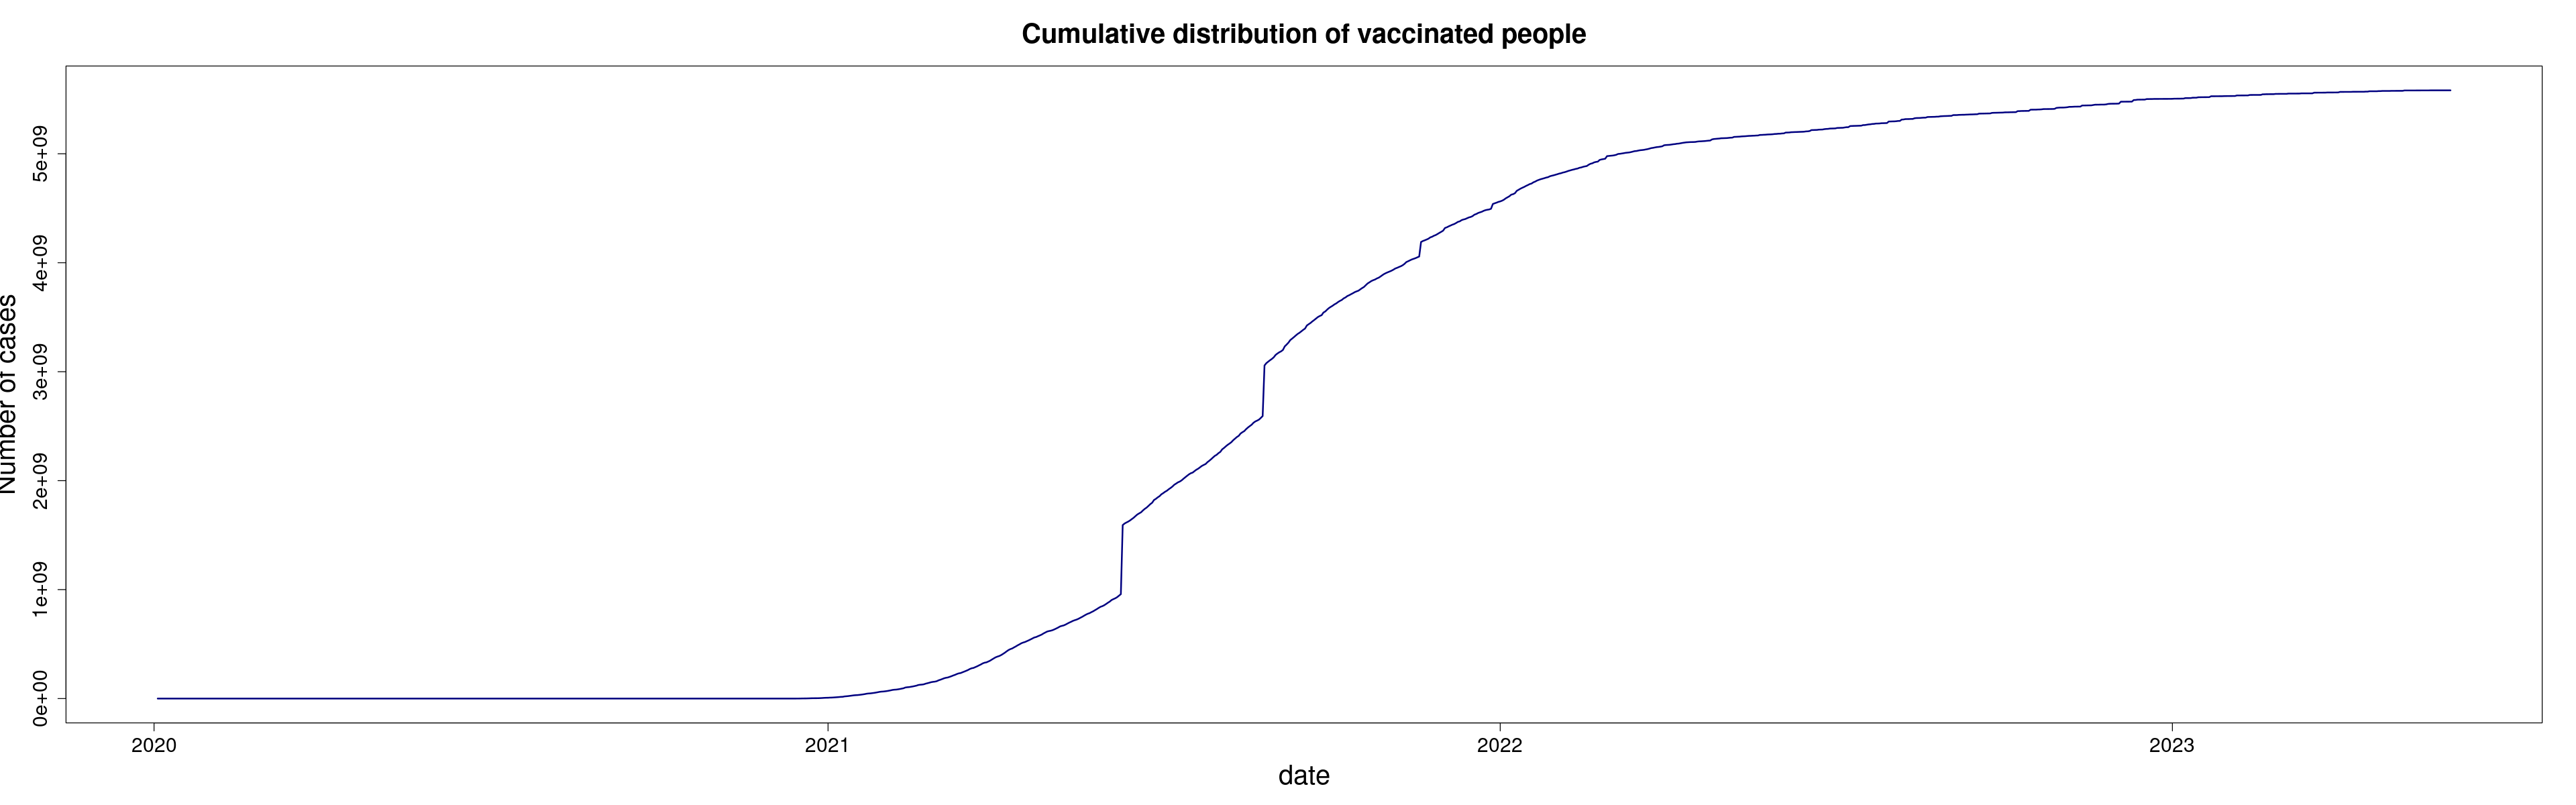

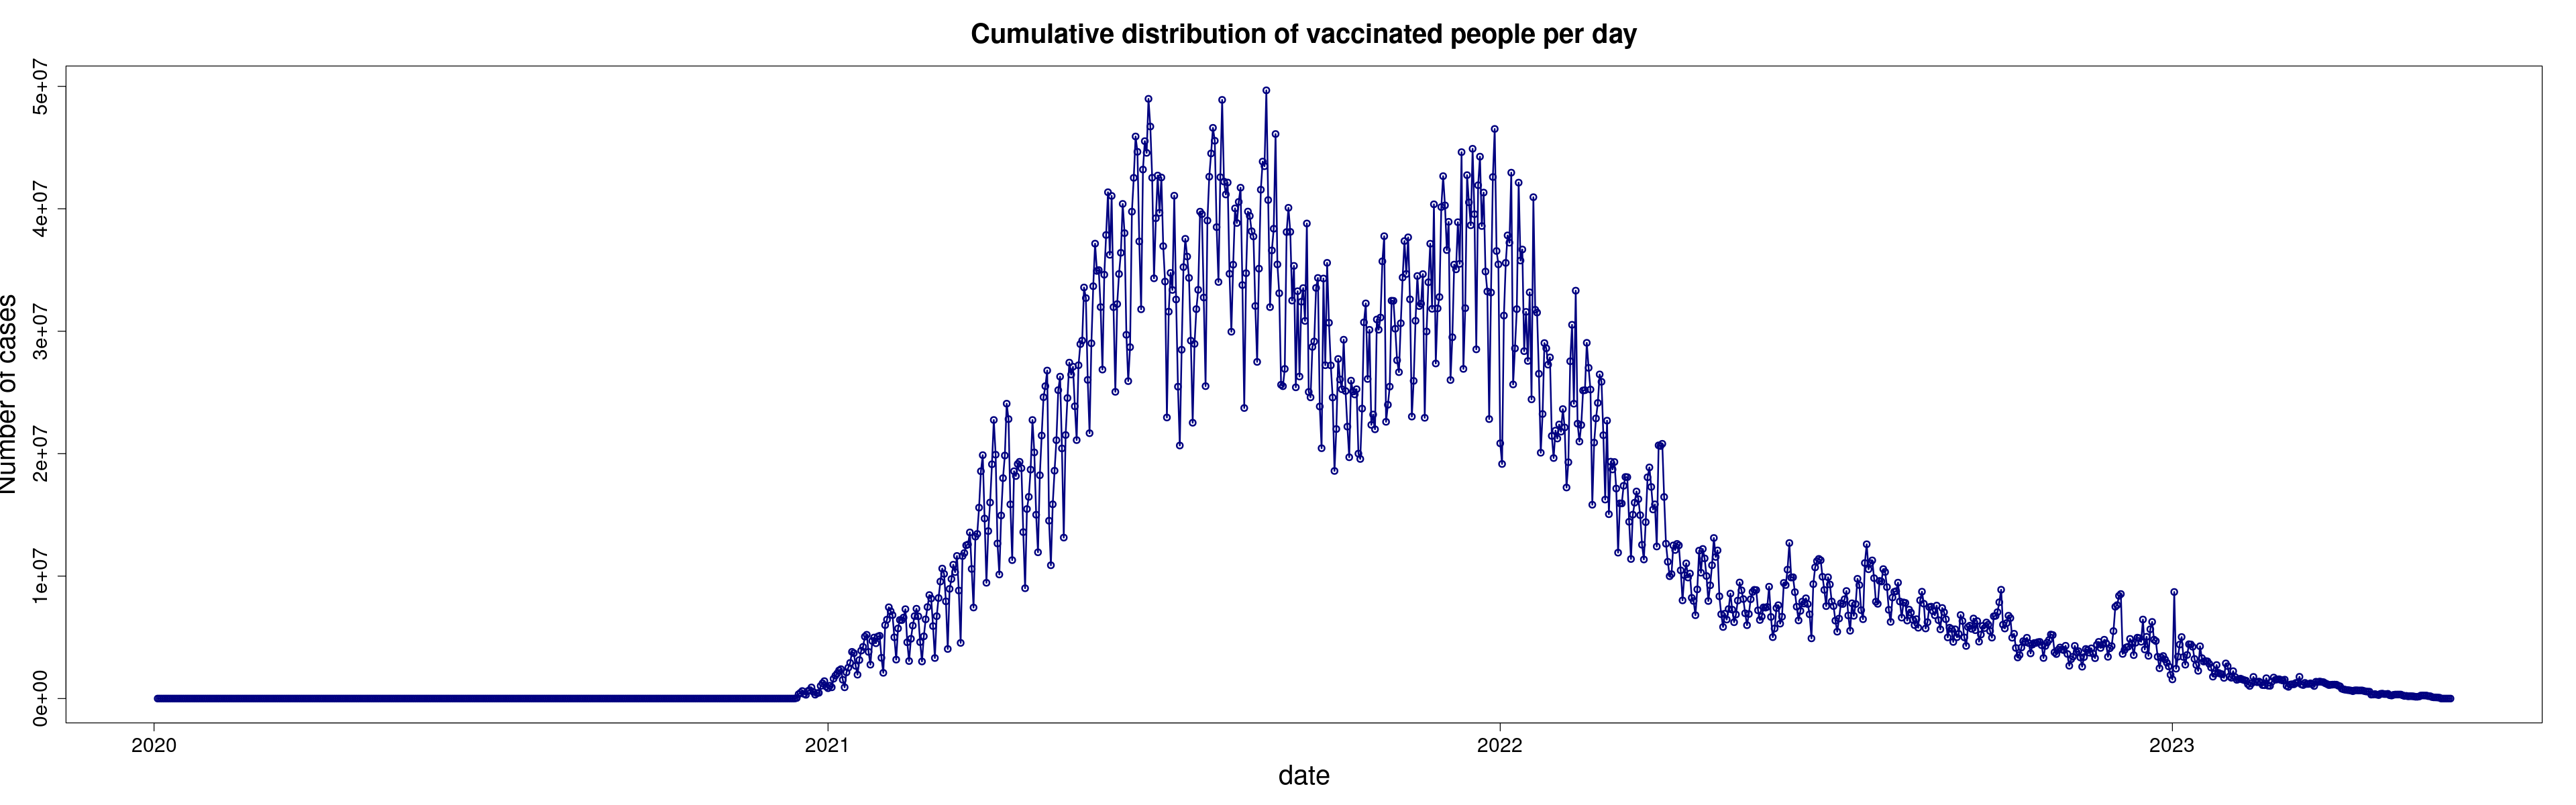

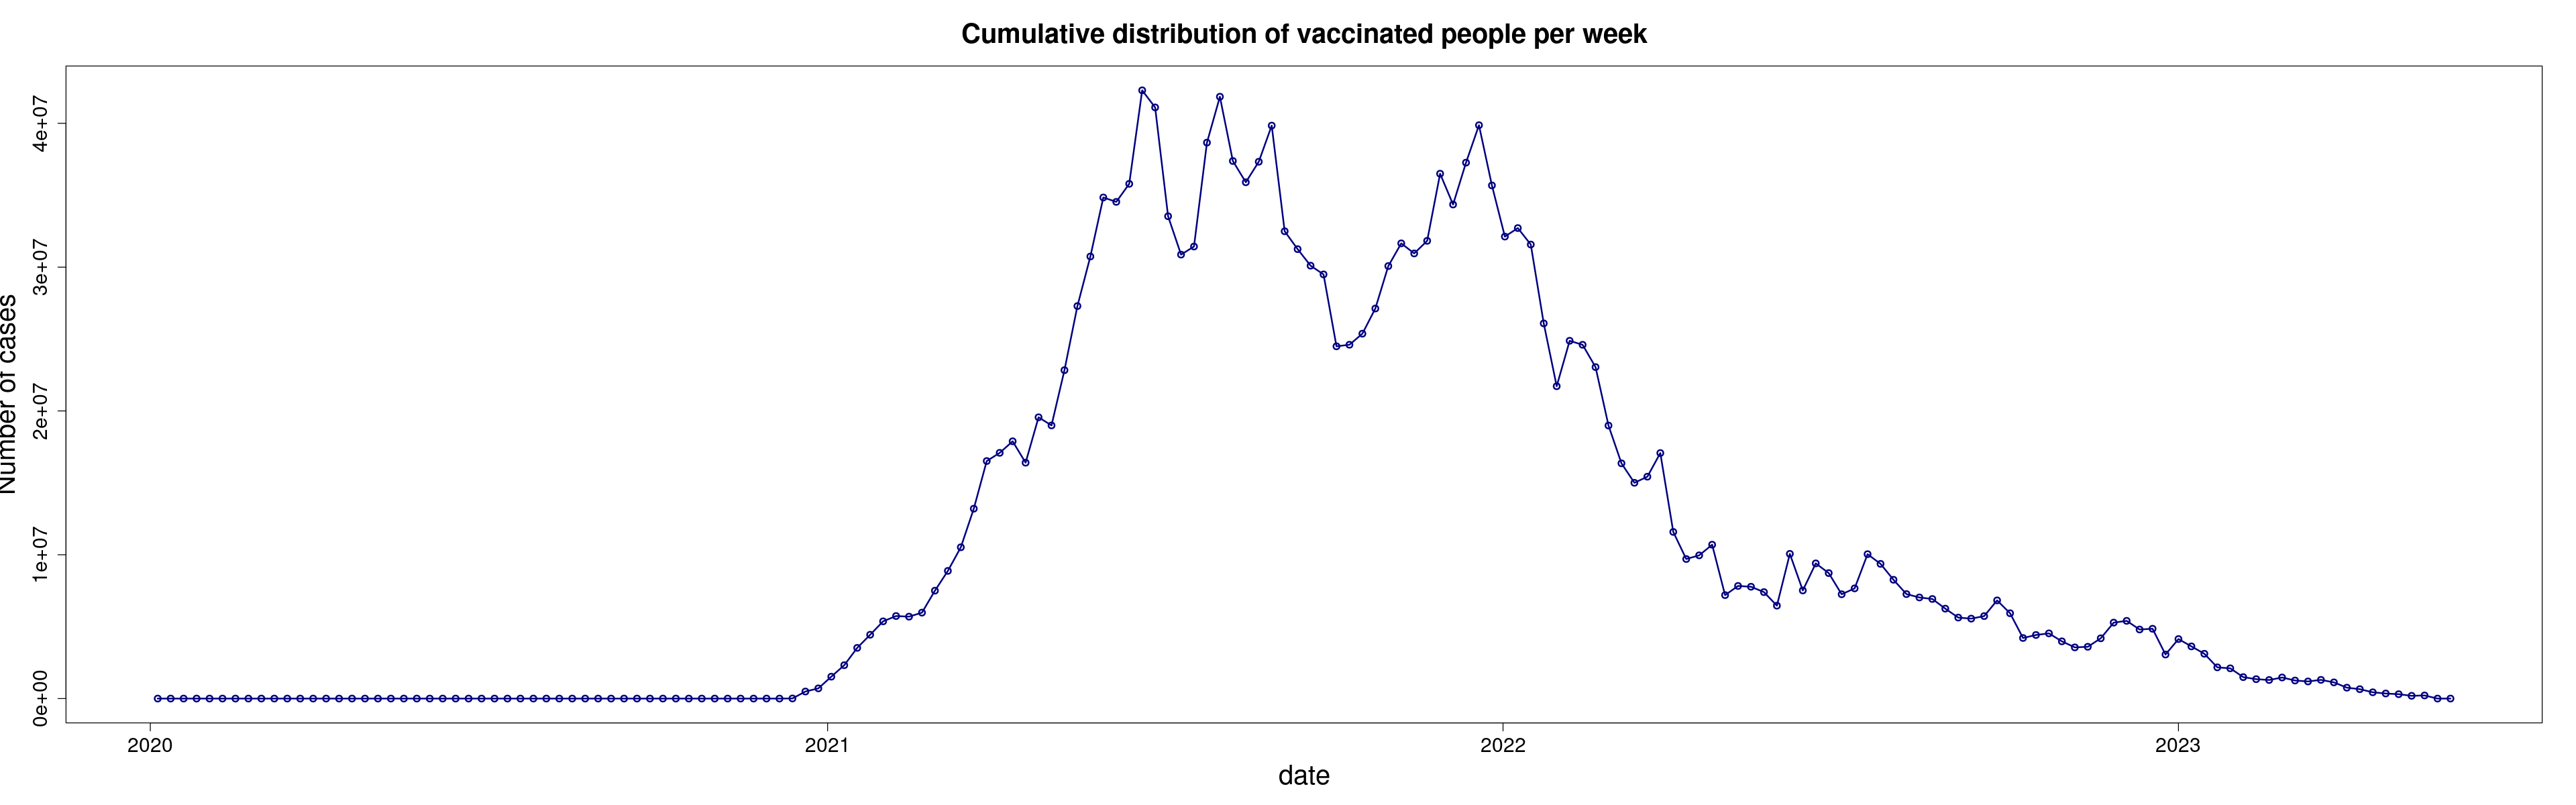

In [5]:
par(cex.main =2 ,cex.lab=2 , cex.axis=1.5)        #increase the size of title, x and y font text for all plots
options(repr.plot.width= 32 , repr.plot.height=10)

plot(world$date , cumulative_vac , type='l', lwd=2 , main=paste('Cumulative distribution of vaccinated people'),
     col= 'navy ',xlab='date', ylab='Number of cases'  )

plot(world$date , daily_vac , type='o',lwd=2 , main=paste('Cumulative distribution of vaccinated people per day'),
     col='navy' ,xlab='date', ylab='Number of cases')
     
plot( weekly_vac$cumulative_week, weekly_vac$total_week , type='o',lwd=2 , main=paste('Cumulative distribution of vaccinated people per week'),
     col= 'navy',xlab='date', ylab='Number of cases')

### b) number of confirmed deaths by COVID-19, both cumulative and weekly average

In [10]:
#for cumulative death

cumulative_deaths <- world$total_deaths

#for daily death

daily_deaths <- world$new_deaths
daily_deaths <- ifelse(is.na(daily_deaths) == TRUE , 0, daily_deaths )       #put 0 instead of NA 

# for weekly death
weekly_deaths <- world %>% group_by(week, year) %>% summarise(total_week =mean(new_deaths))     #using group by to find each week
weekly_deaths$cumulative_week <- as.Date(paste(weekly_deaths$week, weekly_deaths$year, 'Sun'), '%U %Y %a') 
weekly_deaths <- weekly_deaths[order(weekly_deaths$cumulative_week),]


`summarise()` has grouped output by 'week'. You can override using the
`.groups` argument.
Warning message in strptime(x, format, tz = "GMT"):
“(0-based) yday 368 in year 2020 is invalid”
Warning message in strptime(x, format, tz = "GMT"):
“(0-based) yday 366 in year 2021 is invalid”
Warning message in strptime(x, format, tz = "GMT"):
“(0-based) yday 365 in year 2022 is invalid”


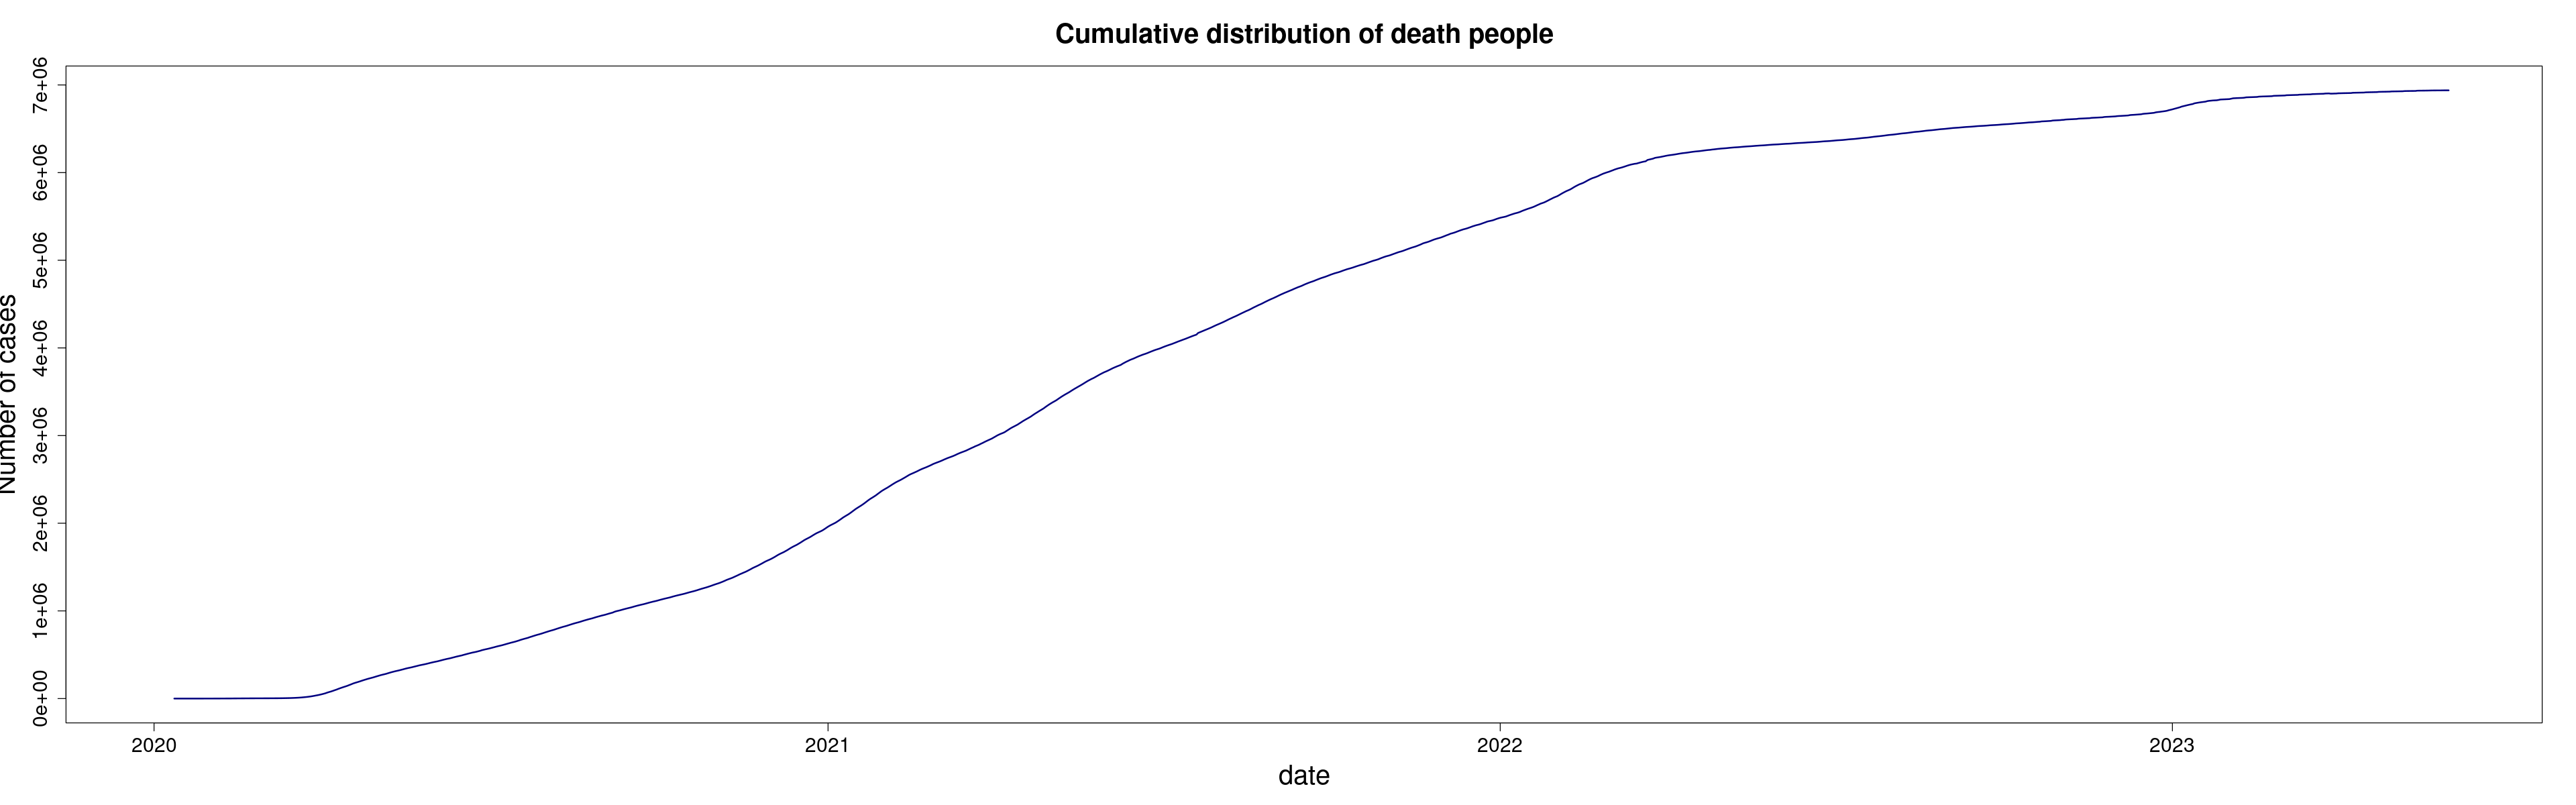

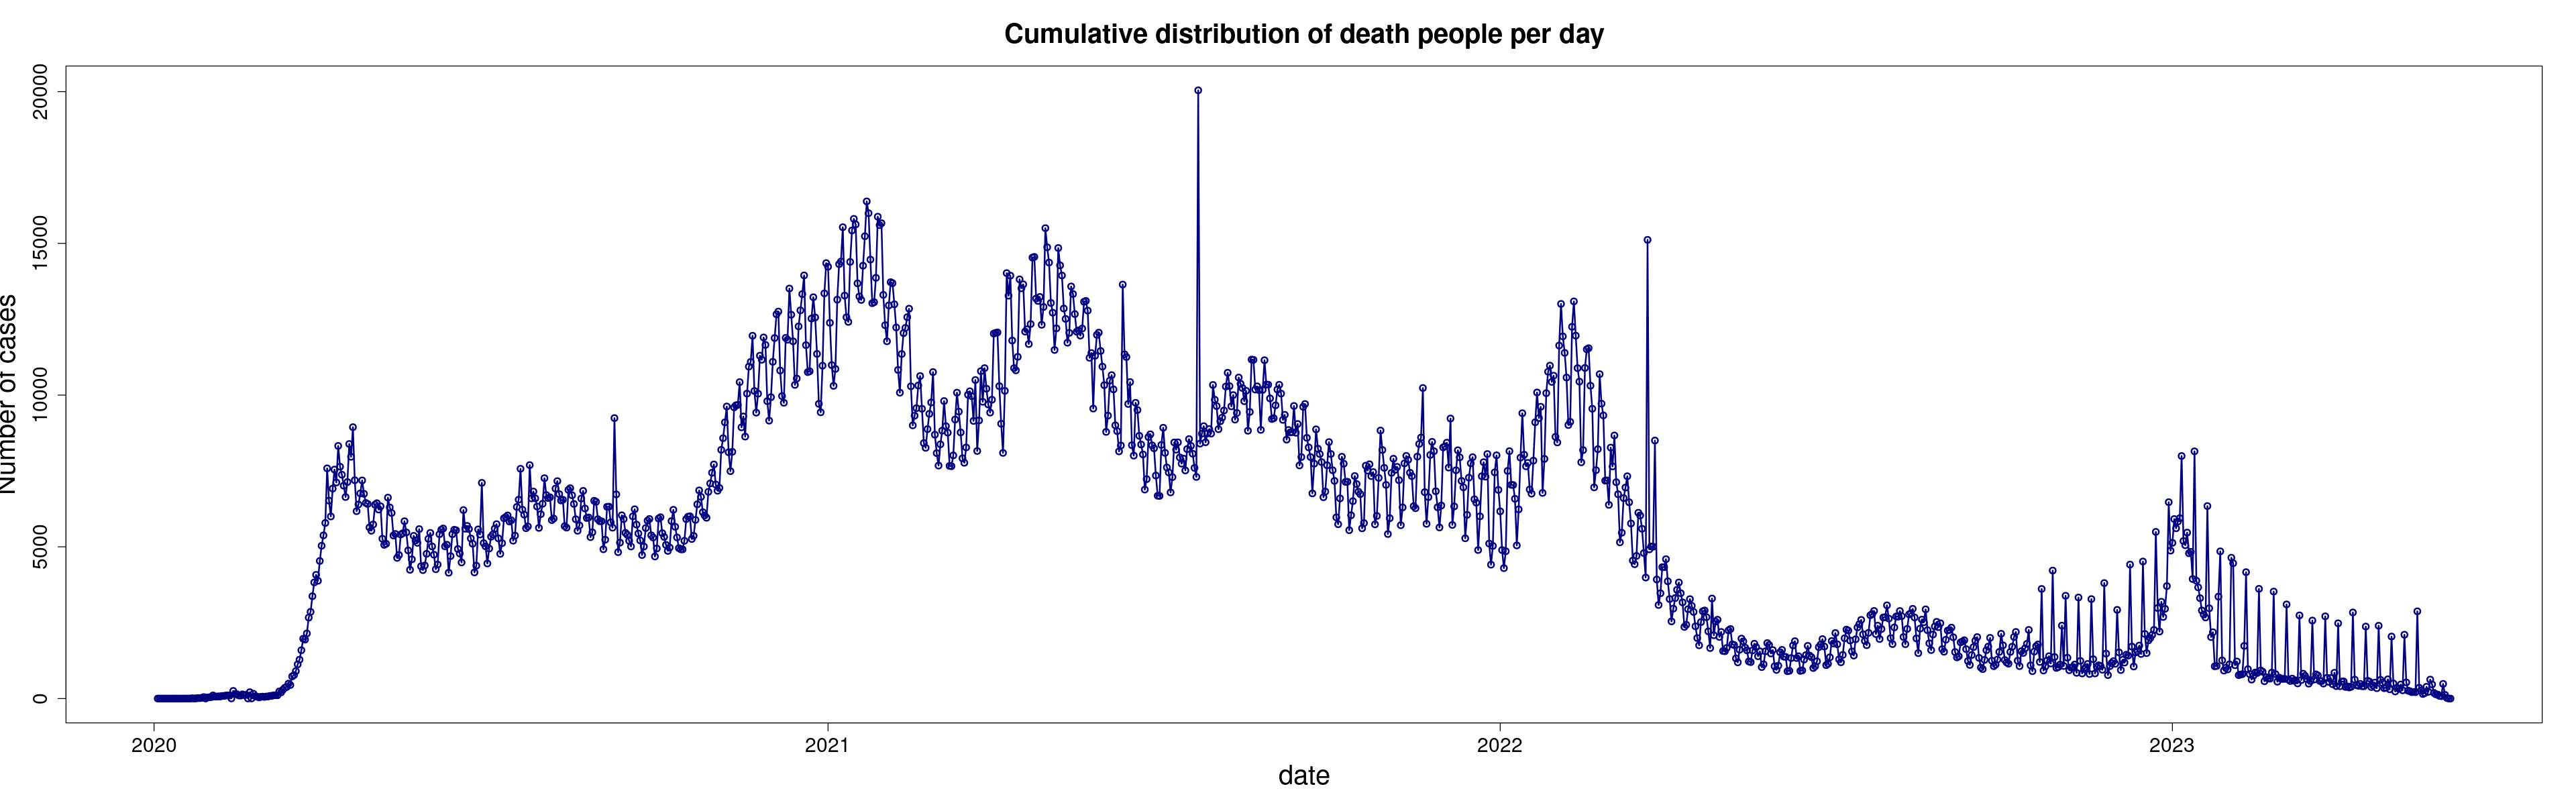

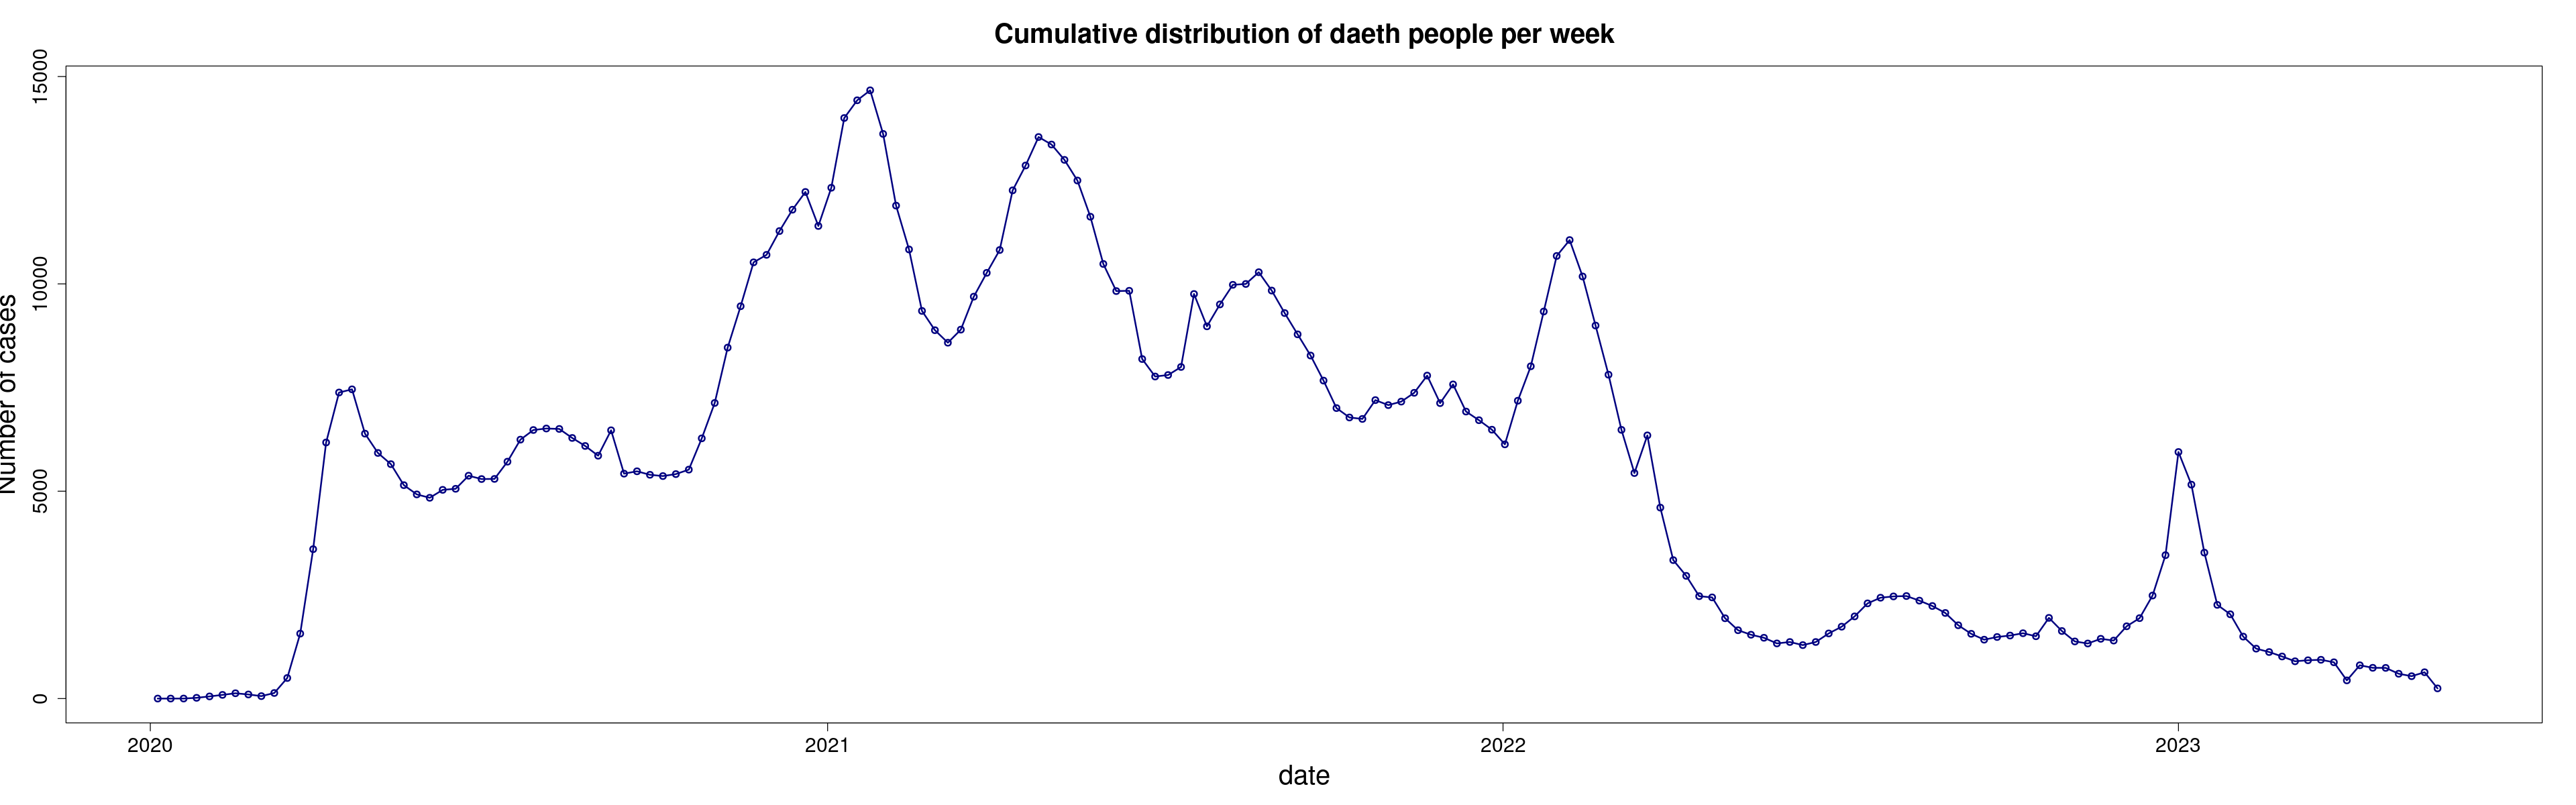

In [11]:
par(cex.main =2 ,cex.lab=2 , cex.axis=1.5)        #increase the size of title, x and y font text for all plots
plot(world$date , cumulative_deaths ,type='l', lwd=2 , main=paste('Cumulative distribution of death people'),
     col= 'navy ',xlab='date', ylab='Number of cases')
     

plot( world$date , daily_deaths,type='o', lwd=2 , main=paste('Cumulative distribution of death people per day'),
     col= 'navy ',xlab='date', ylab='Number of cases')

plot( weekly_deaths$cumulative_week, weekly_deaths$total_week , type='o',lwd=2 , main=paste('Cumulative distribution of daeth people per week'),
     col= 'navy',xlab='date', ylab='Number of cases')